## Comparisons

This code can execute the following three variants of losses:  

1. **Variant 1:**  Purely Physics  
   $L_{\theta} = L_{\text{PDE}}$  
   Use $n_{\text{used}} = 0$  

2. **Variant 2:**  Physics + Data  
   $L_{\theta} = L_{\text{PDE}} + \Sigma_{i=1}^{n_{\text{used}}}\| u_i - \hat{u}_i \|_2^2$  
   Use $n_{\text{used}} \in (0, 1000]$   

All the results presented were obtained as follows:
1. By estimating the gradients in the physics-informed loss terms using forward mode automatic differentiation (AD).
2. The output field values at given grid points were computed in one forward pass of the network using the einsum function.

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import torch.distributions as td
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import argparse
import random
import os
import time 
from sklearn.decomposition import PCA
import pickle

import sys
sys.path.append("../..")
from utils.networks import *
from utils.deeponet_networks_1d import *
from utils.visualizer_misc import *
from utils.visualizer_1d import *
from utils.forward_autodiff import *
from utils.misc import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Tag this cell with 'parameters'
# parameters
seed = 0 # Seed number.
n_used = 100 # Number of full training fields used for estimating the data-driven loss term
save = True # Save results.

In [3]:
# Parameters
seed = 0
n_used = 200
save = True


In [4]:
if save == True:
    resultdir = os.path.join(os.getcwd(),'results','b_Latent-NO','seed='+str(seed)+'_n_used='+str(n_used)) 
    if not os.path.exists(resultdir):
        os.makedirs(resultdir)
else:
    resultdir = None

In [5]:
set_seed(seed)

seed = 0


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
# Load the data
data = np.load(os.path.join('..','..','data/1D_Diffusion-reaction_dynamics_t=0to1/Diffusion-reaction_dynamics.npz')) # Load the .npz file
print(data)
print(data['t_span'].shape)
print(data['x_span'].shape)
print(data['input_s_samples'].shape) # Random Source fields: Gaussian random fields, Nsamples x 100, each sample is (1 x 100)
print(data['output_u_samples'].shape) # Time evolution of the solution field: Nsamples x 101 x 100.
                               # Each field is 101 x 100, rows correspond to time and columns respond to location.
                               # First row corresponds to solution at t=0 (1st time step)
                               # and next  row corresponds to solution at t=0.01 (2nd time step) and so on.
                               # last row correspond to solution at t=1 (101th time step).

NpzFile '../../data/1D_Diffusion-reaction_dynamics_t=0to1/Diffusion-reaction_dynamics.npz' with keys: input_s_samples, output_u_samples, t_span, x_span
(101,)
(100,)
(2500, 100)


(2500, 101, 100)


In [8]:
# Convert NumPy arrays to PyTorch tensors
inputs = torch.from_numpy(data['input_s_samples'][0:1500]).float().to(device)
outputs = torch.from_numpy(data['output_u_samples'][0:1500]).float().to(device)

t_span = torch.from_numpy(data['t_span']).float().to(device)
x_span = torch.from_numpy(data['x_span']).float().to(device)
nt, nx = len(t_span), len(x_span) # number of discretizations in time and location.
print("nt =",nt, ", nx =",nx)
print("Shape of t-span and x-span:",t_span.shape, x_span.shape)
print("t-span:", t_span)
print("x-span:", x_span)

# Estimating grid points
T, X = torch.meshgrid(t_span, x_span)
# print(T)
# print(X)

# Split the data into training and testing samples
inputs_train, inputs_test, outputs_train, outputs_test = train_test_split(inputs, outputs, test_size=500, random_state=seed)

# Check the shapes of the subsets
print("Shape of inputs_train:", inputs_train.shape)
print("Shape of inputs_test:", inputs_test.shape)
print("Shape of outputs_train:", outputs_train.shape)
print("Shape of outputs_test:", outputs_test.shape)
print('#'*100)

nt = 101 , nx = 100
Shape of t-span and x-span: torch.Size([101]) torch.Size([100])
t-span: tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900, 1.0000], dev

In [9]:
# Of these full training fields available I am using only n_used fields for estimating the data-driven loss term in the PI-Latent-NO
inputs_train_used = inputs_train[:n_used, :]
print("Shape of inputs_train_used:", inputs_train_used.shape)
outputs_train_used = outputs_train[:n_used, :, :]
print("Shape of outputs_train_used:", outputs_train_used.shape)

Shape of inputs_train_used: torch.Size([200, 100])
Shape of outputs_train_used: torch.Size([200, 101, 100])


In [10]:
latent_dim = 9 # d_z

In [11]:
"""
input_neurons_latent_branch: Number of input neurons in the latent_branch net.
input_neurons_latent_trunk: Number of input neurons in the latent_trunk net.
latent_p: Number of output neurons in both the latent_branch and latent_trunk net.
"""
latent_p = latent_dim*25 # Number of output neurons in both the latent_branch and latent_trunk net.

input_neurons_latent_branch = nx # m
latent_branch_net = DenseNet(layersizes=[input_neurons_latent_branch] + [64]*3 + [latent_p], activation=nn.SiLU()) #nn.LeakyReLU() #nn.Tanh()
latent_branch_net.to(device)
# print(latent_branch_net)
print('LATENT BRANCH-NET SUMMARY:')
summary(latent_branch_net, input_size=(input_neurons_latent_branch,))  
print('#'*100)

input_neurons_latent_trunk = 1 # 1 corresponds to t
latent_trunk_net = DenseNet(layersizes=[input_neurons_latent_trunk] + [64]*3 + [latent_p], activation=nn.SiLU()) #nn.LeakyReLU() #nn.Tanh()
latent_trunk_net.to(device)
# print(latent_trunk_net)
print('LATENT TRUNK-NET SUMMARY:')
summary(latent_trunk_net, input_size=(input_neurons_latent_trunk,))
print('#'*100)

"""
input_neurons_reconstruction_branch: Number of input neurons in the reconstruction_branch net.
input_neurons_reconstruction_trunk: Number of input neurons in the reconstruction_trunk net.
reconstruction_q: Number of output neurons in both the reconstruction_branch and reconstruction_trunk net.
"""
reconstruction_q = 128 # Number of output neurons in both the reconstruction_branch and reconstruction_trunk net.

input_neurons_reconstruction_branch = latent_dim # d_z
reconstruction_branch_net = DenseNet(layersizes=[input_neurons_reconstruction_branch] + [64]*3 + [reconstruction_q], activation=nn.SiLU()) #nn.LeakyReLU() #nn.Tanh()
reconstruction_branch_net.to(device)
# print(reconstruction_branch_net)
print('RECONSTRUCTION BRANCH-NET SUMMARY:')
summary(reconstruction_branch_net, input_size=(input_neurons_reconstruction_branch,))  
print('#'*100)

input_neurons_reconstruction_trunk = 1 # 1 corresponds to x
reconstruction_trunk_net = DenseNet(layersizes=[input_neurons_reconstruction_trunk] + [64]*3 + [reconstruction_q], activation=nn.SiLU()) #nn.LeakyReLU() #nn.Tanh()
reconstruction_trunk_net.to(device)
# print(reconstruction_trunk_net)
print('RECONSTRUCTION TRUNK-NET SUMMARY:')
summary(reconstruction_trunk_net, input_size=(input_neurons_reconstruction_trunk,))
print('#'*100)

model = Latent_NO_model(latent_branch_net, latent_trunk_net, latent_dim, reconstruction_branch_net, reconstruction_trunk_net)
model.to(device);

LATENT BRANCH-NET SUMMARY:


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           6,464
              SiLU-2                   [-1, 64]               0
            Linear-3                   [-1, 64]           4,160
              SiLU-4                   [-1, 64]               0
            Linear-5                   [-1, 64]           4,160
              SiLU-6                   [-1, 64]               0
            Linear-7                  [-1, 225]          14,625
Total params: 29,409
Trainable params: 29,409
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.11
Estimated Total Size (MB): 0.12
----------------------------------------------------------------
####################################################################################################
LATENT 

In [12]:
num_learnable_parameters = (count_learnable_parameters(latent_branch_net)
                            + count_learnable_parameters(latent_trunk_net)
                            + count_learnable_parameters(reconstruction_branch_net)
                            + count_learnable_parameters(reconstruction_trunk_net))
print("Total number of learnable parameters:", num_learnable_parameters)

Total number of learnable parameters: 86530


In [13]:
def loss_pde_residual(net, source_fields, t, x):
    
    _, u = net(source_fields, t, x) # u is (bs, neval_t, neval_x)
    
    # Using forward automatic differention to estimate derivatives in the physics informed loss
    tangent_t, tangent_x = torch.ones(t.shape).to(device), torch.ones(x.shape).to(device)
    ut  = FWDAD_first_order_derivative(lambda t: net(source_fields, t, x)[1], t, tangent_t) # (bs, neval_t, neval_x)
    uxx = FWDAD_second_order_derivative(lambda x: net(source_fields, t, x)[1], x, tangent_x) # (bs, neval_t, neval_x)
    
    bs_ = source_fields.shape[0]
    sf_values_ = torch.zeros((bs_, x.shape[0], 1)).to(device)
    for j in range(bs_):
        sf_values_[j] = linear_interpolation_1D(x, x_span, source_fields[j]) # source function: s(x) values
    sf_values__ = sf_values_.reshape(-1, 1, x.shape[0]) # (bs, 1, neval_x)
    # Repeat elements along neval_x for neval_t times and reshape
    sf_values = sf_values__.repeat(1, neval_t, 1) # (bs, neval_t, neval_x) # s(x) values are same for all times
    
    pde_residual = (ut - (0.01*uxx) - (0.01*(u**2)) - sf_values)**2
    
    return torch.mean(pde_residual)

In [14]:
def loss_pde_bcs(net, source_fields, t, x):
    
    t_b1, x_b1 = t[0], x[0]
    t_b2, x_b2 = t[1], x[1]

    _, u_b1 = net(source_fields, t_b1, x_b1) # u is (bs, neval_t, 1)
    _, u_b2 = net(source_fields, t_b2, x_b2) # u is (bs, neval_t, 1)

    bc1_value, bc2_value = 0., 0.
    pde_bc1 = (u_b1 - bc1_value)**2
    pde_bc2 = (u_b2 - bc2_value)**2
    
    return torch.mean(pde_bc1) + torch.mean(pde_bc2)

In [15]:
def loss_pde_ic(net, source_fields, t, x):

    _, u_ic = net(source_fields, t, x) # u is (bs, 1, neval_x)
    
    ic_value = 0.
    pde_ic = (u_ic - ic_value)**2
    
    return torch.mean(pde_ic)

Iteration 0 - loss = 1.209254, data-driven loss = 0.246132, pinn loss = 0.963122, learning rate = 0.003500, test loss = 0.320931


Iteration 500 - loss = 0.195776, data-driven loss = 0.023230, pinn loss = 0.172547, learning rate = 0.003500, test loss = 0.019992


Iteration 1000 - loss = 0.088193, data-driven loss = 0.008941, pinn loss = 0.079252, learning rate = 0.003500, test loss = 0.009442


Iteration 1500 - loss = 0.109291, data-driven loss = 0.009584, pinn loss = 0.099707, learning rate = 0.003500, test loss = 0.011237


Iteration 2000 - loss = 0.056379, data-driven loss = 0.003182, pinn loss = 0.053197, learning rate = 0.003500, test loss = 0.004147


Iteration 2500 - loss = 0.037132, data-driven loss = 0.003401, pinn loss = 0.033731, learning rate = 0.003500, test loss = 0.003415


Iteration 3000 - loss = 0.030816, data-driven loss = 0.003340, pinn loss = 0.027475, learning rate = 0.003500, test loss = 0.003293


Iteration 3500 - loss = 0.010406, data-driven loss = 0.000960, pinn loss = 0.009446, learning rate = 0.003500, test loss = 0.001099


Iteration 4000 - loss = 0.012801, data-driven loss = 0.000991, pinn loss = 0.011810, learning rate = 0.003500, test loss = 0.001044


Iteration 4500 - loss = 0.014685, data-driven loss = 0.001271, pinn loss = 0.013415, learning rate = 0.003500, test loss = 0.001094


Iteration 5000 - loss = 0.012360, data-driven loss = 0.000893, pinn loss = 0.011468, learning rate = 0.003500, test loss = 0.001398


Iteration 5500 - loss = 0.005642, data-driven loss = 0.000354, pinn loss = 0.005289, learning rate = 0.003500, test loss = 0.000405


Iteration 6000 - loss = 0.010327, data-driven loss = 0.001208, pinn loss = 0.009119, learning rate = 0.003500, test loss = 0.002360


Iteration 6500 - loss = 0.004507, data-driven loss = 0.000367, pinn loss = 0.004140, learning rate = 0.003500, test loss = 0.000410


Iteration 7000 - loss = 0.004200, data-driven loss = 0.000309, pinn loss = 0.003891, learning rate = 0.003500, test loss = 0.000338


Iteration 7500 - loss = 0.006782, data-driven loss = 0.000610, pinn loss = 0.006172, learning rate = 0.003500, test loss = 0.000980


Iteration 8000 - loss = 0.008454, data-driven loss = 0.001122, pinn loss = 0.007332, learning rate = 0.003500, test loss = 0.000921


Iteration 8500 - loss = 0.002502, data-driven loss = 0.000355, pinn loss = 0.002147, learning rate = 0.003500, test loss = 0.000274


Iteration 9000 - loss = 0.005589, data-driven loss = 0.000693, pinn loss = 0.004896, learning rate = 0.003500, test loss = 0.000611


Iteration 9500 - loss = 0.002082, data-driven loss = 0.000131, pinn loss = 0.001951, learning rate = 0.003500, test loss = 0.000226


Iteration 10000 - loss = 0.001618, data-driven loss = 0.000108, pinn loss = 0.001510, learning rate = 0.003500, test loss = 0.000132


Iteration 10500 - loss = 0.004845, data-driven loss = 0.000676, pinn loss = 0.004169, learning rate = 0.003500, test loss = 0.000867


Iteration 11000 - loss = 0.002344, data-driven loss = 0.000218, pinn loss = 0.002126, learning rate = 0.003500, test loss = 0.000185


Iteration 11500 - loss = 0.001843, data-driven loss = 0.000141, pinn loss = 0.001702, learning rate = 0.003500, test loss = 0.000198


Iteration 12000 - loss = 0.001269, data-driven loss = 0.000100, pinn loss = 0.001169, learning rate = 0.003500, test loss = 0.000152


Iteration 12500 - loss = 0.002223, data-driven loss = 0.000338, pinn loss = 0.001885, learning rate = 0.003500, test loss = 0.000222


Iteration 13000 - loss = 0.000595, data-driven loss = 0.000040, pinn loss = 0.000555, learning rate = 0.003500, test loss = 0.000046


Iteration 13500 - loss = 0.003668, data-driven loss = 0.000579, pinn loss = 0.003088, learning rate = 0.003500, test loss = 0.000677


Iteration 14000 - loss = 0.001899, data-driven loss = 0.000212, pinn loss = 0.001687, learning rate = 0.003500, test loss = 0.000292


Iteration 14500 - loss = 0.001805, data-driven loss = 0.000261, pinn loss = 0.001544, learning rate = 0.003500, test loss = 0.000256


Iteration 15000 - loss = 0.006284, data-driven loss = 0.001111, pinn loss = 0.005173, learning rate = 0.000350, test loss = 0.000931


Iteration 15500 - loss = 0.000252, data-driven loss = 0.000009, pinn loss = 0.000243, learning rate = 0.000350, test loss = 0.000019


Iteration 16000 - loss = 0.000266, data-driven loss = 0.000008, pinn loss = 0.000257, learning rate = 0.000350, test loss = 0.000018


Iteration 16500 - loss = 0.000241, data-driven loss = 0.000007, pinn loss = 0.000234, learning rate = 0.000350, test loss = 0.000017


Iteration 17000 - loss = 0.000247, data-driven loss = 0.000007, pinn loss = 0.000239, learning rate = 0.000350, test loss = 0.000016


Iteration 17500 - loss = 0.000252, data-driven loss = 0.000008, pinn loss = 0.000244, learning rate = 0.000350, test loss = 0.000017


Iteration 18000 - loss = 0.000233, data-driven loss = 0.000008, pinn loss = 0.000224, learning rate = 0.000350, test loss = 0.000015


Iteration 18500 - loss = 0.000246, data-driven loss = 0.000009, pinn loss = 0.000237, learning rate = 0.000350, test loss = 0.000018


Iteration 19000 - loss = 0.000251, data-driven loss = 0.000010, pinn loss = 0.000241, learning rate = 0.000350, test loss = 0.000018


Iteration 19500 - loss = 0.000253, data-driven loss = 0.000008, pinn loss = 0.000245, learning rate = 0.000350, test loss = 0.000016


Iteration 20000 - loss = 0.000176, data-driven loss = 0.000008, pinn loss = 0.000167, learning rate = 0.000350, test loss = 0.000015


Iteration 20500 - loss = 0.000186, data-driven loss = 0.000007, pinn loss = 0.000179, learning rate = 0.000350, test loss = 0.000014


Iteration 21000 - loss = 0.000268, data-driven loss = 0.000018, pinn loss = 0.000250, learning rate = 0.000350, test loss = 0.000017


Iteration 21500 - loss = 0.000234, data-driven loss = 0.000008, pinn loss = 0.000227, learning rate = 0.000350, test loss = 0.000013


Iteration 22000 - loss = 0.000168, data-driven loss = 0.000007, pinn loss = 0.000162, learning rate = 0.000350, test loss = 0.000011


Iteration 22500 - loss = 0.000173, data-driven loss = 0.000011, pinn loss = 0.000162, learning rate = 0.000350, test loss = 0.000022


Iteration 23000 - loss = 0.000199, data-driven loss = 0.000008, pinn loss = 0.000191, learning rate = 0.000350, test loss = 0.000011


Iteration 23500 - loss = 0.000186, data-driven loss = 0.000007, pinn loss = 0.000178, learning rate = 0.000350, test loss = 0.000013


Iteration 24000 - loss = 0.000182, data-driven loss = 0.000008, pinn loss = 0.000173, learning rate = 0.000350, test loss = 0.000017


Iteration 24500 - loss = 0.000186, data-driven loss = 0.000009, pinn loss = 0.000176, learning rate = 0.000350, test loss = 0.000014


Iteration 25000 - loss = 0.000148, data-driven loss = 0.000006, pinn loss = 0.000142, learning rate = 0.000350, test loss = 0.000011


Iteration 25500 - loss = 0.000156, data-driven loss = 0.000008, pinn loss = 0.000148, learning rate = 0.000350, test loss = 0.000011


Iteration 26000 - loss = 0.000176, data-driven loss = 0.000007, pinn loss = 0.000169, learning rate = 0.000350, test loss = 0.000010


Iteration 26500 - loss = 0.000152, data-driven loss = 0.000010, pinn loss = 0.000142, learning rate = 0.000350, test loss = 0.000013


Iteration 27000 - loss = 0.000201, data-driven loss = 0.000008, pinn loss = 0.000193, learning rate = 0.000350, test loss = 0.000012


Iteration 27500 - loss = 0.000201, data-driven loss = 0.000007, pinn loss = 0.000194, learning rate = 0.000350, test loss = 0.000011


Iteration 28000 - loss = 0.000210, data-driven loss = 0.000007, pinn loss = 0.000203, learning rate = 0.000350, test loss = 0.000014


Iteration 28500 - loss = 0.000202, data-driven loss = 0.000013, pinn loss = 0.000189, learning rate = 0.000350, test loss = 0.000012


Iteration 29000 - loss = 0.000188, data-driven loss = 0.000008, pinn loss = 0.000180, learning rate = 0.000350, test loss = 0.000015


Iteration 29500 - loss = 0.000234, data-driven loss = 0.000010, pinn loss = 0.000224, learning rate = 0.000350, test loss = 0.000012


Iteration 30000 - loss = 0.000207, data-driven loss = 0.000008, pinn loss = 0.000199, learning rate = 0.000035, test loss = 0.000010


Iteration 30500 - loss = 0.000152, data-driven loss = 0.000005, pinn loss = 0.000147, learning rate = 0.000035, test loss = 0.000008


Iteration 31000 - loss = 0.000147, data-driven loss = 0.000005, pinn loss = 0.000142, learning rate = 0.000035, test loss = 0.000008


Iteration 31500 - loss = 0.000146, data-driven loss = 0.000005, pinn loss = 0.000141, learning rate = 0.000035, test loss = 0.000008


Iteration 32000 - loss = 0.000133, data-driven loss = 0.000005, pinn loss = 0.000128, learning rate = 0.000035, test loss = 0.000008


Iteration 32500 - loss = 0.000138, data-driven loss = 0.000005, pinn loss = 0.000133, learning rate = 0.000035, test loss = 0.000008


Iteration 33000 - loss = 0.000114, data-driven loss = 0.000004, pinn loss = 0.000109, learning rate = 0.000035, test loss = 0.000008


Iteration 33500 - loss = 0.000165, data-driven loss = 0.000004, pinn loss = 0.000161, learning rate = 0.000035, test loss = 0.000008


Iteration 34000 - loss = 0.000170, data-driven loss = 0.000005, pinn loss = 0.000165, learning rate = 0.000035, test loss = 0.000008


Iteration 34500 - loss = 0.000193, data-driven loss = 0.000005, pinn loss = 0.000187, learning rate = 0.000035, test loss = 0.000008


Iteration 35000 - loss = 0.000148, data-driven loss = 0.000005, pinn loss = 0.000143, learning rate = 0.000035, test loss = 0.000008


Iteration 35500 - loss = 0.000124, data-driven loss = 0.000005, pinn loss = 0.000119, learning rate = 0.000035, test loss = 0.000008


Iteration 36000 - loss = 0.000150, data-driven loss = 0.000005, pinn loss = 0.000145, learning rate = 0.000035, test loss = 0.000008


Iteration 36500 - loss = 0.000157, data-driven loss = 0.000005, pinn loss = 0.000152, learning rate = 0.000035, test loss = 0.000008


Iteration 37000 - loss = 0.000176, data-driven loss = 0.000004, pinn loss = 0.000172, learning rate = 0.000035, test loss = 0.000008


Iteration 37500 - loss = 0.000124, data-driven loss = 0.000004, pinn loss = 0.000120, learning rate = 0.000035, test loss = 0.000008


Iteration 38000 - loss = 0.000130, data-driven loss = 0.000005, pinn loss = 0.000125, learning rate = 0.000035, test loss = 0.000008


Iteration 38500 - loss = 0.000141, data-driven loss = 0.000004, pinn loss = 0.000137, learning rate = 0.000035, test loss = 0.000008


Iteration 39000 - loss = 0.000140, data-driven loss = 0.000004, pinn loss = 0.000136, learning rate = 0.000035, test loss = 0.000008


Iteration 39500 - loss = 0.000137, data-driven loss = 0.000004, pinn loss = 0.000133, learning rate = 0.000035, test loss = 0.000008


Iteration 40000 - loss = 0.000115, data-driven loss = 0.000004, pinn loss = 0.000110, learning rate = 0.000035, test loss = 0.000008


Iteration 40500 - loss = 0.000150, data-driven loss = 0.000004, pinn loss = 0.000146, learning rate = 0.000035, test loss = 0.000008


Iteration 41000 - loss = 0.000131, data-driven loss = 0.000005, pinn loss = 0.000127, learning rate = 0.000035, test loss = 0.000008


Iteration 41500 - loss = 0.000117, data-driven loss = 0.000005, pinn loss = 0.000112, learning rate = 0.000035, test loss = 0.000007


Iteration 42000 - loss = 0.000101, data-driven loss = 0.000004, pinn loss = 0.000097, learning rate = 0.000035, test loss = 0.000008


Iteration 42500 - loss = 0.000136, data-driven loss = 0.000005, pinn loss = 0.000132, learning rate = 0.000035, test loss = 0.000008


Iteration 43000 - loss = 0.000153, data-driven loss = 0.000005, pinn loss = 0.000147, learning rate = 0.000035, test loss = 0.000008


Iteration 43500 - loss = 0.000159, data-driven loss = 0.000004, pinn loss = 0.000155, learning rate = 0.000035, test loss = 0.000008


Iteration 44000 - loss = 0.000123, data-driven loss = 0.000004, pinn loss = 0.000119, learning rate = 0.000035, test loss = 0.000008


Iteration 44500 - loss = 0.000130, data-driven loss = 0.000005, pinn loss = 0.000125, learning rate = 0.000035, test loss = 0.000007


Iteration 45000 - loss = 0.000140, data-driven loss = 0.000005, pinn loss = 0.000135, learning rate = 0.000004, test loss = 0.000008


Iteration 45500 - loss = 0.000125, data-driven loss = 0.000004, pinn loss = 0.000121, learning rate = 0.000004, test loss = 0.000007


Iteration 46000 - loss = 0.000129, data-driven loss = 0.000004, pinn loss = 0.000125, learning rate = 0.000004, test loss = 0.000007


Iteration 46500 - loss = 0.000124, data-driven loss = 0.000004, pinn loss = 0.000120, learning rate = 0.000004, test loss = 0.000007


Iteration 47000 - loss = 0.000112, data-driven loss = 0.000004, pinn loss = 0.000108, learning rate = 0.000004, test loss = 0.000007


Iteration 47500 - loss = 0.000172, data-driven loss = 0.000004, pinn loss = 0.000169, learning rate = 0.000004, test loss = 0.000007


Iteration 48000 - loss = 0.000133, data-driven loss = 0.000004, pinn loss = 0.000129, learning rate = 0.000004, test loss = 0.000007


Iteration 48500 - loss = 0.000149, data-driven loss = 0.000004, pinn loss = 0.000145, learning rate = 0.000004, test loss = 0.000007


Iteration 49000 - loss = 0.000150, data-driven loss = 0.000004, pinn loss = 0.000146, learning rate = 0.000004, test loss = 0.000007


Iteration 49500 - loss = 0.000127, data-driven loss = 0.000004, pinn loss = 0.000123, learning rate = 0.000004, test loss = 0.000007


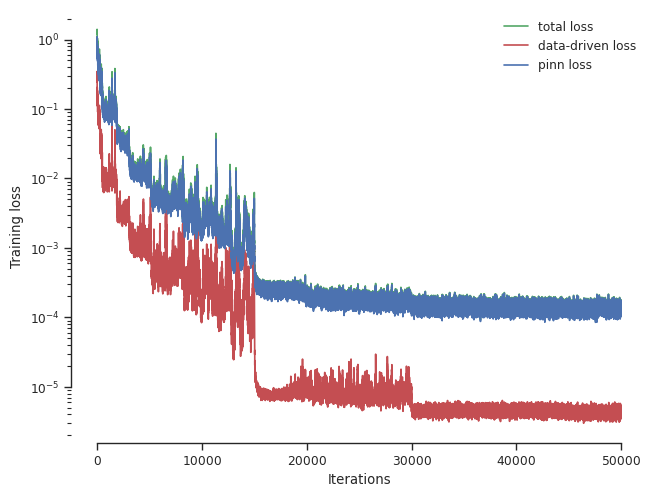

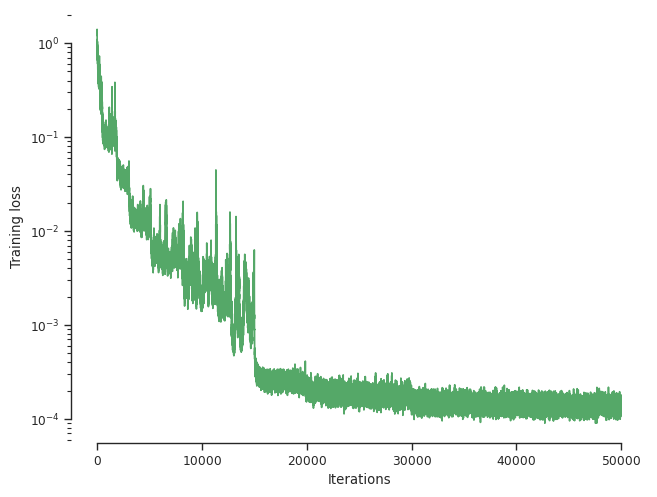

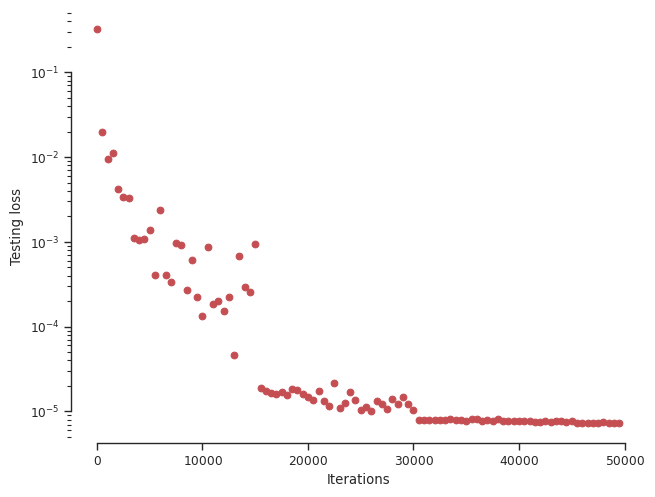

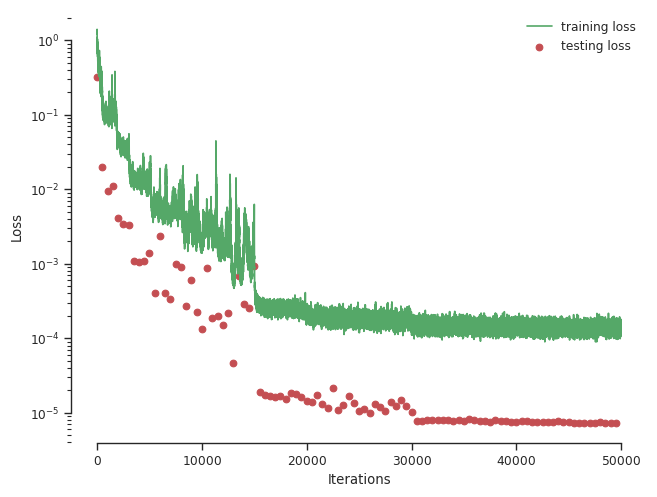

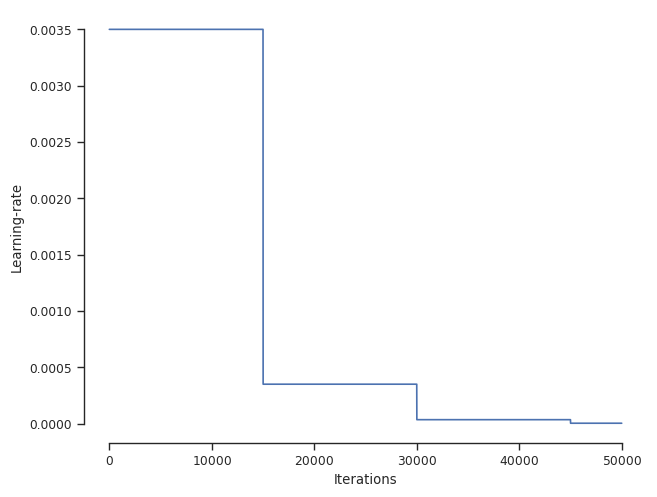

In [16]:
start_time = time.time()

bs = 64 # Batch size
neval_t = 256  # Number of time points at which latent output field is evaluated for a given input source field sample
neval_x = 256 
# neval_loc = neval_x  # Number of locations at which output field is evaluated at each time point.

neval_c = {'t': neval_t, 'loc': neval_x}  # Number of collocation points within the domain.
neval_b = {'t': neval_t, 'loc': 1}        # Number of collocation points on each boundary.
neval_i = {'t': 1, 'loc': neval_x}        # Number of collocation points at t=0.
        
# Training
optimizer = torch.optim.Adam(model.parameters(), lr=3.5*1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15000, gamma=0.1) # gamma=0.8

iteration_list, loss_list, learningrates_list = [], [], []
datadriven_loss_list, pinn_loss_list = [], []
test_iteration_list, test_loss_list = [], []

n_iterations = 50000
for iteration in range(n_iterations):
    
    if n_used == 0:
        datadriven_loss = torch.tensor([0.]).to(device)
        # print('*********')
    else:
        indices_datadriven = torch.randperm(n_used).to(device) # Generate random permutation of indices
        inputs_train_used_batch = inputs_train_used[indices_datadriven[0:bs]]
        outputs_train_used_batch = outputs_train_used[indices_datadriven[0:bs]]
        #print("Shape of inputs_train_used_batch:", inputs_train_used_batch.shape) # (bs, nx)
        #print("Shape of outputs_train_used_batch:", outputs_train_used_batch.shape) # (bs, nt, nx)

        _, reconstruction_predicted_values = model(inputs_train_used_batch, t_span.reshape(-1, 1), x_span.reshape(-1, 1)) # (bs, nt, latent_dim), (bs, nt, nx)
        reconstruction_target_values = outputs_train_used_batch # (bs, nt, nx)
        datadriven_loss = nn.MSELoss()(reconstruction_predicted_values, reconstruction_target_values)
        # print('*********')
    
    indices_pinn = torch.randperm(len(inputs_train)).to(device) # Generate random permutation of indices
    inputs_batch = inputs_train[indices_pinn[0:bs]]
    #print(f"Shape of inputs_batch:", inputs_batch.shape) # (bs, nx)
    
    # points within the domain
    tc = td.uniform.Uniform(0., 1.).sample((neval_c['t'], 1)).to(device)
    xc = td.uniform.Uniform(0., 1.).sample((neval_c['loc'], 1)).to(device)

    # boundary points on the 2 boundaries (hard-coded)
    tb = [td.uniform.Uniform(0., 1.).sample((neval_b['t'], 1)).to(device),
          td.uniform.Uniform(0., 1.).sample((neval_b['t'], 1)).to(device)]
    xb = [torch.tensor([[0.]]).to(device), 
          torch.tensor([[1.]]).to(device)]

    # initial points
    ti = torch.zeros((1, 1)).to(device)
    xi = td.uniform.Uniform(0., 1.).sample((neval_i['loc'], 1)).to(device)

    pinn_loss = (loss_pde_residual(model, inputs_batch, tc, xc) 
               + loss_pde_bcs(model, inputs_batch, tb, xb) 
               + loss_pde_ic(model, inputs_batch, ti, xi))
    # print('*********')

    optimizer.zero_grad()
    loss = datadriven_loss + pinn_loss
    loss.backward()
    # torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()
    scheduler.step()

    if iteration % 500 == 0:
        # Test loss calculation
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            test_predicted_values = model(inputs_test, 
                              t_span.reshape(-1, 1), 
                              x_span.reshape(-1, 1))[1]  # (bs, neval) = (bs, nt, nx)
            test_loss = nn.MSELoss()(test_predicted_values, outputs_test.reshape(-1, nt, nx))
            test_iteration_list.append(iteration)
            test_loss_list.append(test_loss.item())  
        model.train()  # Switch back to training mode
        print('Iteration %s -' % iteration, 'loss = %f,' % loss,
              'data-driven loss = %f,' % datadriven_loss,'pinn loss = %f,' % pinn_loss,
              'learning rate = %f,' % optimizer.state_dict()['param_groups'][0]['lr'], 
              'test loss = %f' % test_loss)

    iteration_list.append(iteration)
    loss_list.append(loss.item())
    datadriven_loss_list.append(datadriven_loss.item())
    pinn_loss_list.append(pinn_loss.item())
    learningrates_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
    
if save == True:
    np.save(os.path.join(resultdir,'iteration_list.npy'), np.asarray(iteration_list))
    np.save(os.path.join(resultdir,'loss_list.npy'), np.asarray(loss_list))
    np.save(os.path.join(resultdir, 'datadriven_loss_list.npy'), np.asarray(datadriven_loss_list))
    np.save(os.path.join(resultdir, 'pinn_loss_list.npy'), np.asarray(pinn_loss_list))
    np.save(os.path.join(resultdir,'learningrates_list.npy'), np.asarray(learningrates_list))
    np.save(os.path.join(resultdir,'test_iteration_list.npy'), np.asarray(test_iteration_list))
    np.save(os.path.join(resultdir, 'test_loss_list.npy'), np.asarray(test_loss_list)) 

plot_loss_terms(resultdir, iteration_list, loss_list, datadriven_loss_list, pinn_loss_list, save)  
    
plot_training_loss(resultdir, iteration_list, loss_list, save) 

plot_testing_loss(resultdir, test_iteration_list, test_loss_list, save)

plot_training_testing_loss(resultdir, iteration_list, loss_list, test_iteration_list, test_loss_list, save)

plot_learningrates(resultdir, iteration_list, learningrates_list, save)  
    
# end timer
end_time = time.time()
training_time = end_time - start_time

runtime_per_iter = training_time/n_iterations # in sec/iter

In [17]:
if save == True:
    torch.save(model.state_dict(), os.path.join(resultdir,'model_state_dict.pt'))
# model.load_state_dict(torch.load(os.path.join(resultdir,'model_state_dict.pt'), map_location=device))

TEST SAMPLE 10
Rel. L2 Error = 0.0086, R2 score = 0.9999


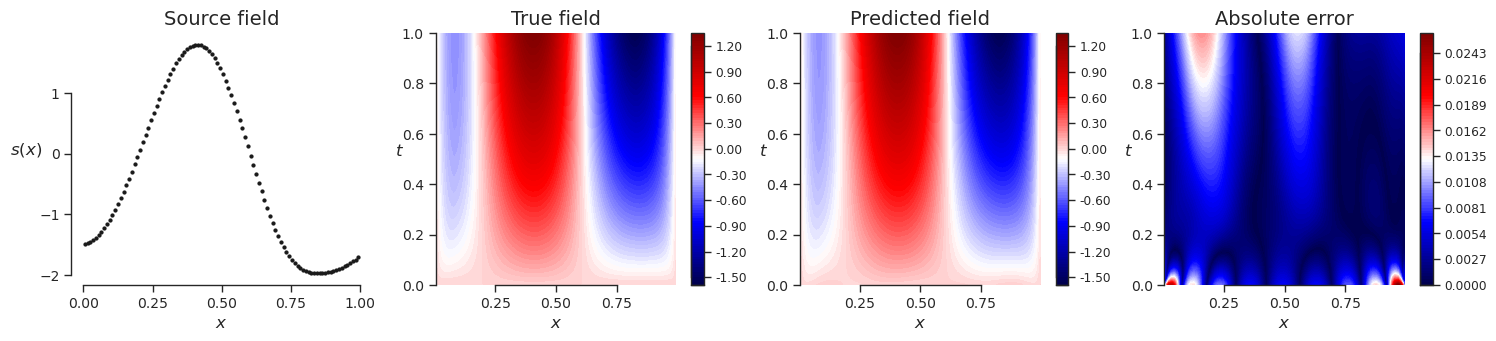

######################################################################################################################################################################################################################################
TEST SAMPLE 20
Rel. L2 Error = 0.0051, R2 score = 1.0


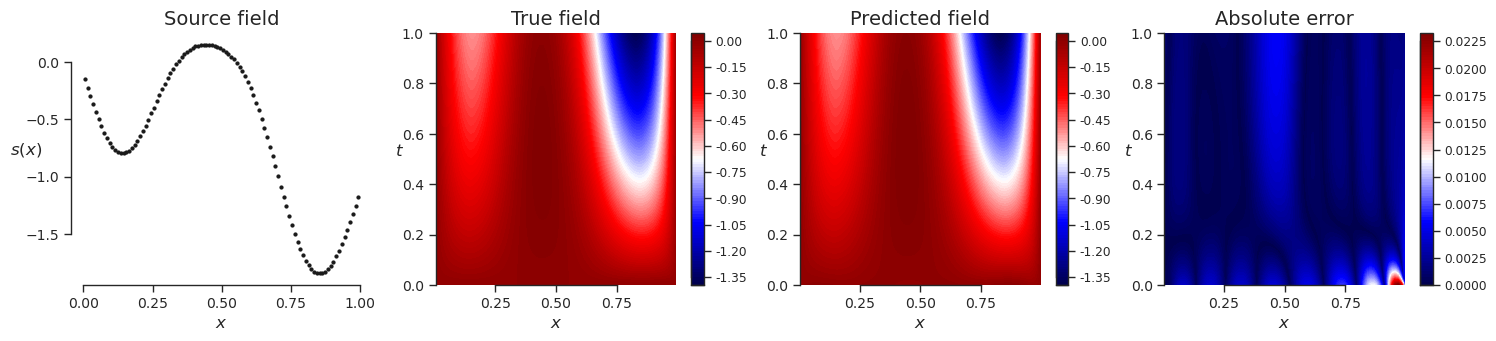

######################################################################################################################################################################################################################################
TEST SAMPLE 30
Rel. L2 Error = 0.0105, R2 score = 0.9999


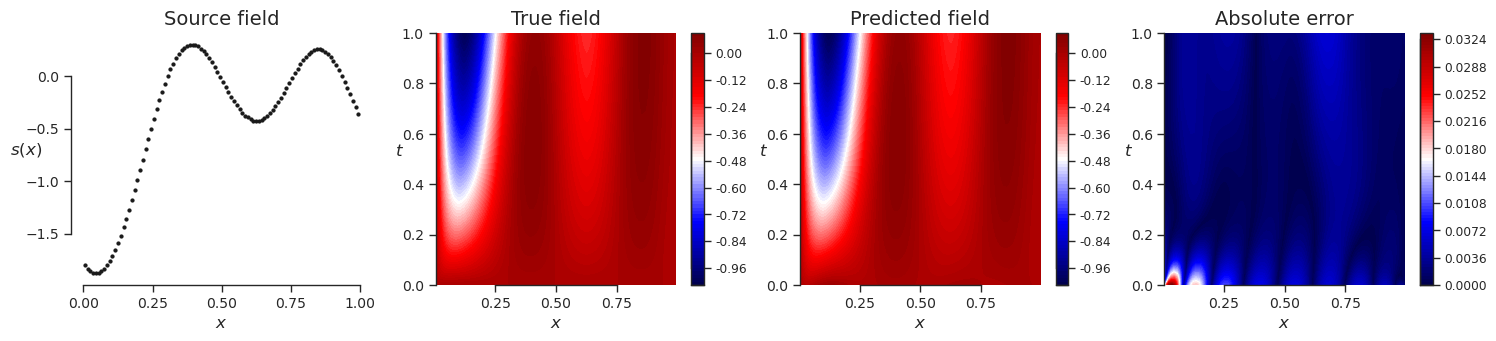

######################################################################################################################################################################################################################################
TEST SAMPLE 40
Rel. L2 Error = 0.0018, R2 score = 1.0


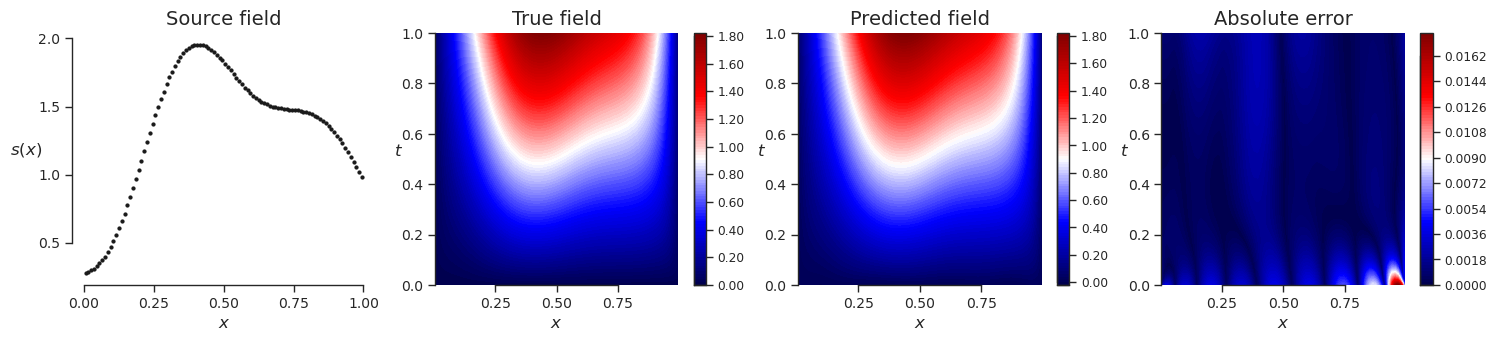

######################################################################################################################################################################################################################################
TEST SAMPLE 50
Rel. L2 Error = 0.0037, R2 score = 1.0


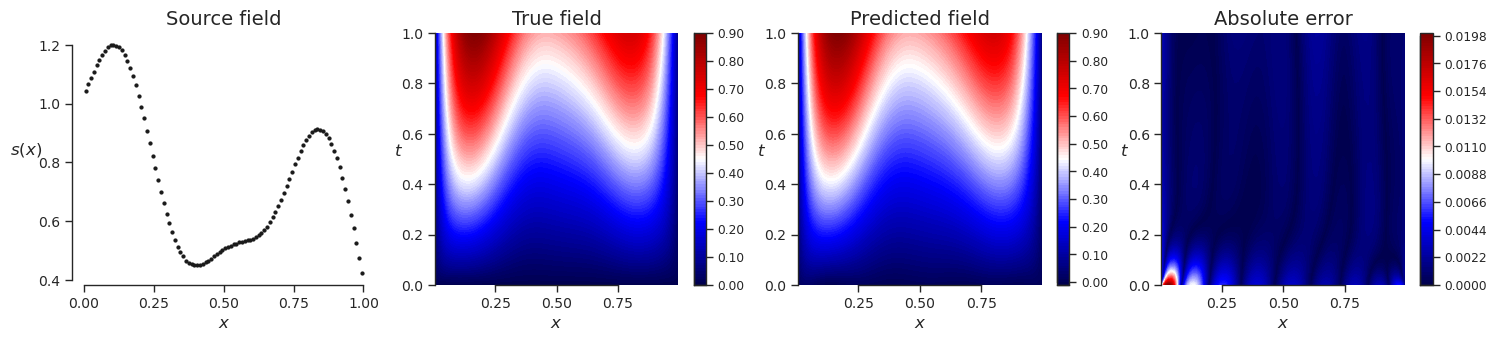

######################################################################################################################################################################################################################################
TEST SAMPLE 60
Rel. L2 Error = 0.008, R2 score = 0.9999


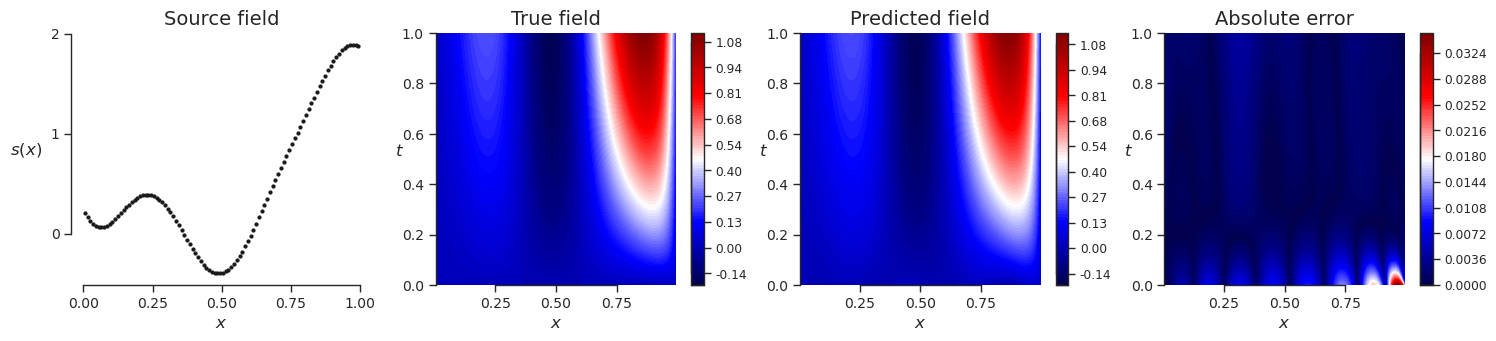

######################################################################################################################################################################################################################################
TEST SAMPLE 70
Rel. L2 Error = 0.0081, R2 score = 0.9999


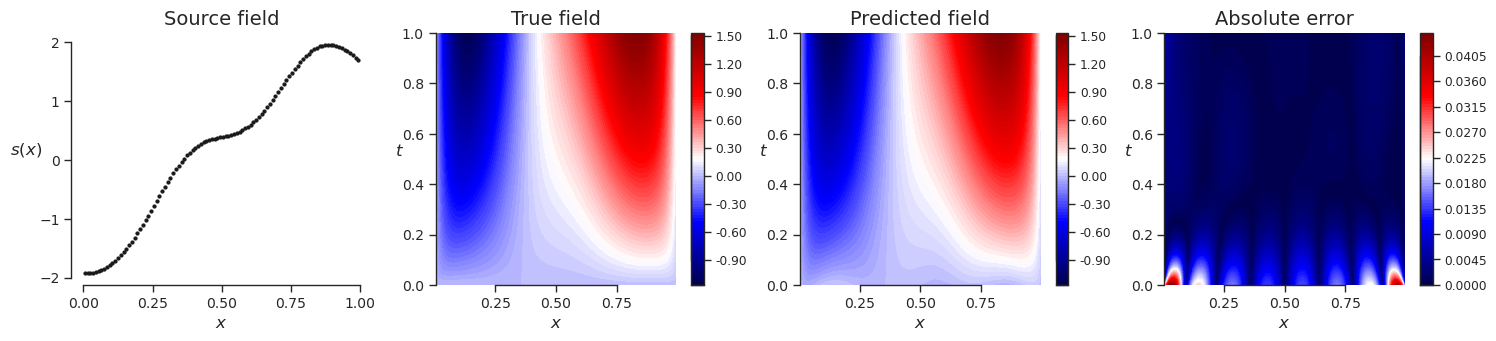

######################################################################################################################################################################################################################################
TEST SAMPLE 80
Rel. L2 Error = 0.0019, R2 score = 1.0


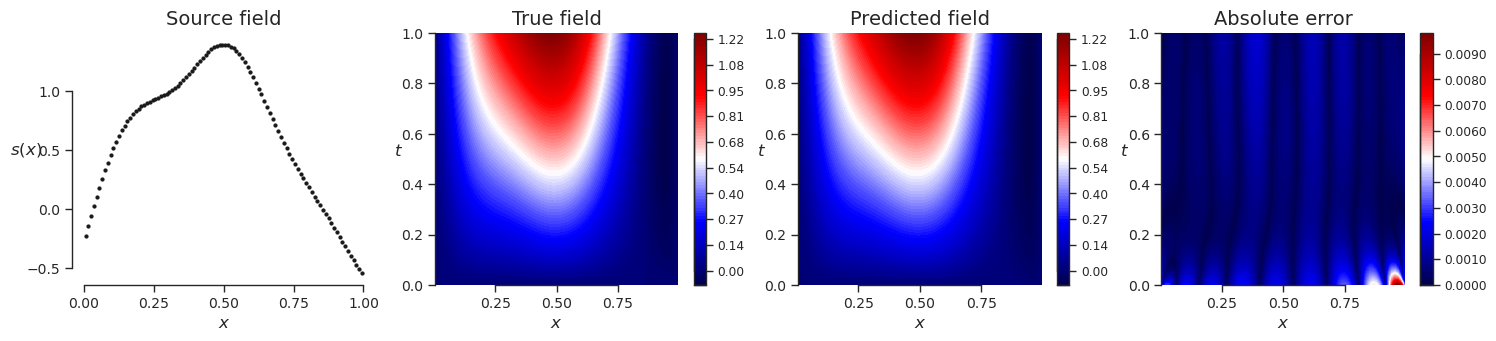

######################################################################################################################################################################################################################################
TEST SAMPLE 90
Rel. L2 Error = 0.0045, R2 score = 1.0


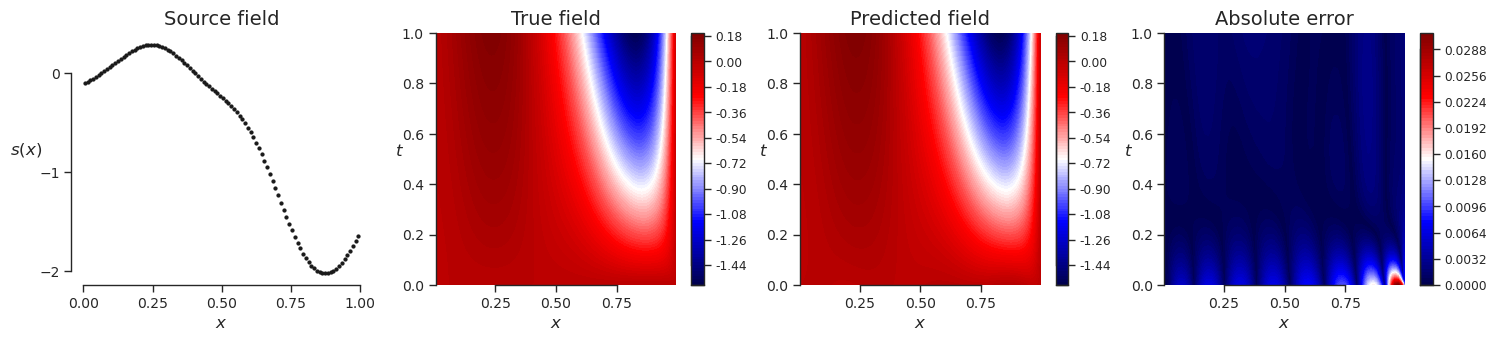

######################################################################################################################################################################################################################################
TEST SAMPLE 100
Rel. L2 Error = 0.0023, R2 score = 1.0


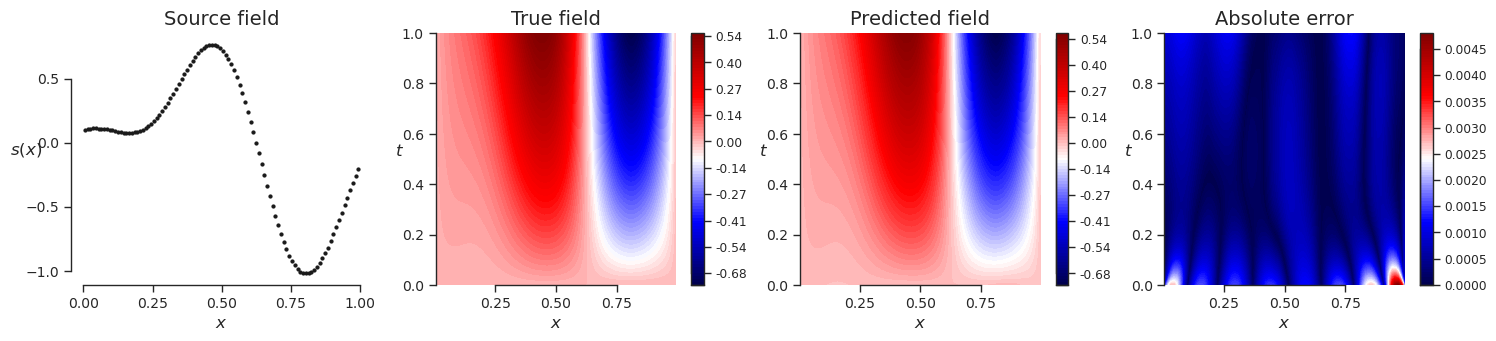

######################################################################################################################################################################################################################################
TEST SAMPLE 110
Rel. L2 Error = 0.0052, R2 score = 1.0


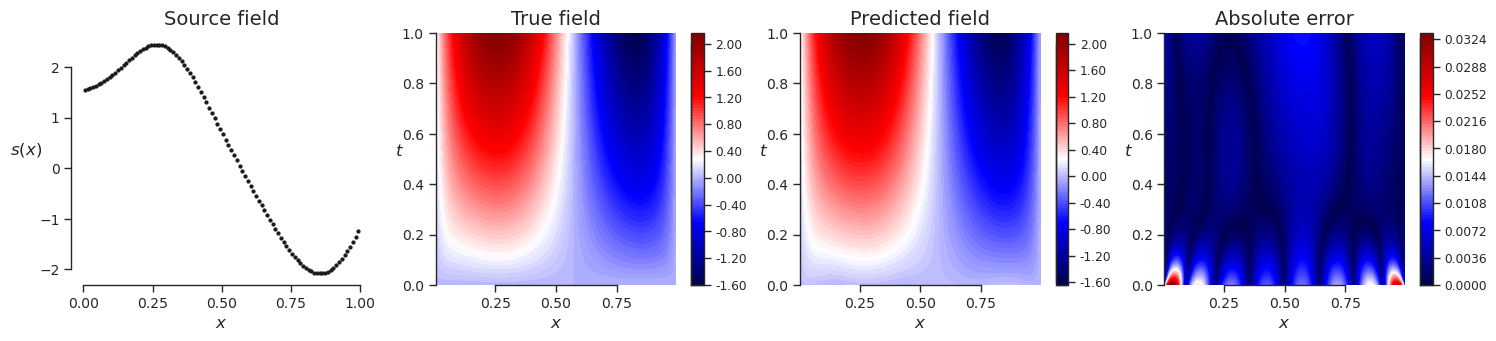

######################################################################################################################################################################################################################################
TEST SAMPLE 120
Rel. L2 Error = 0.0022, R2 score = 1.0


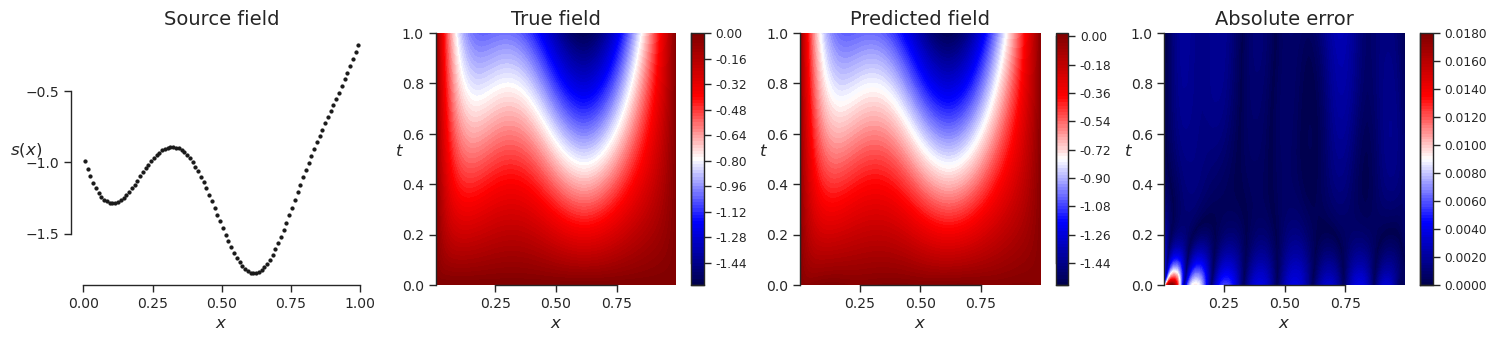

######################################################################################################################################################################################################################################
TEST SAMPLE 130
Rel. L2 Error = 0.0057, R2 score = 1.0


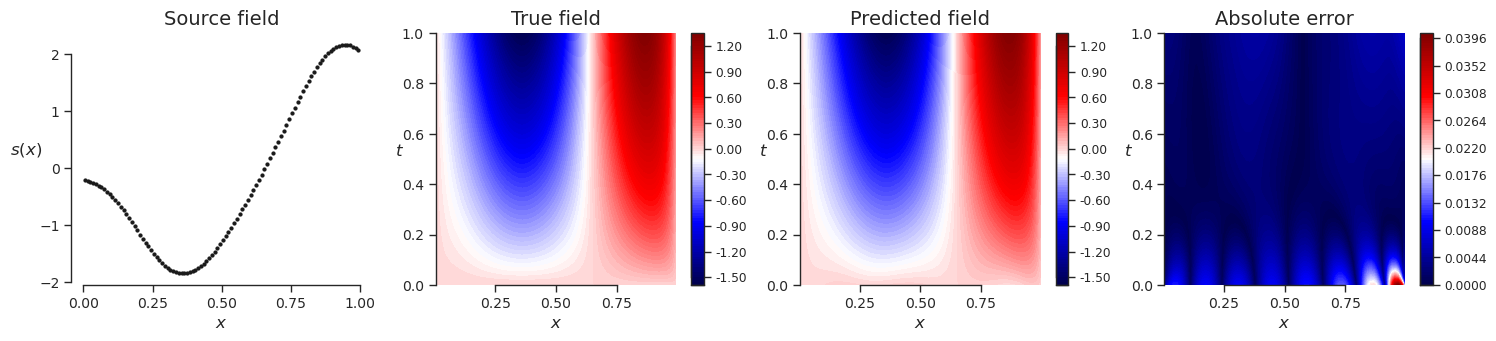

######################################################################################################################################################################################################################################
TEST SAMPLE 140
Rel. L2 Error = 0.007, R2 score = 0.9999


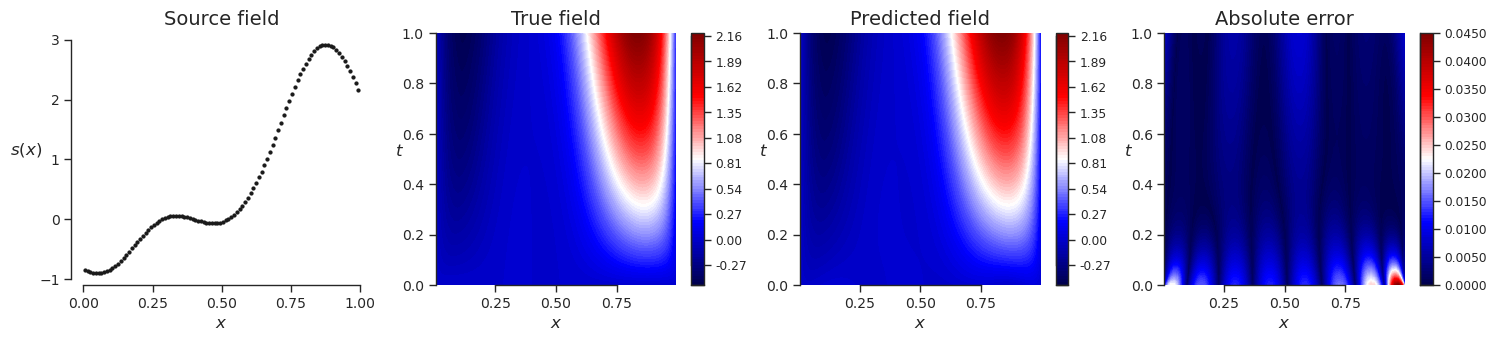

######################################################################################################################################################################################################################################
TEST SAMPLE 150
Rel. L2 Error = 0.0075, R2 score = 0.9998


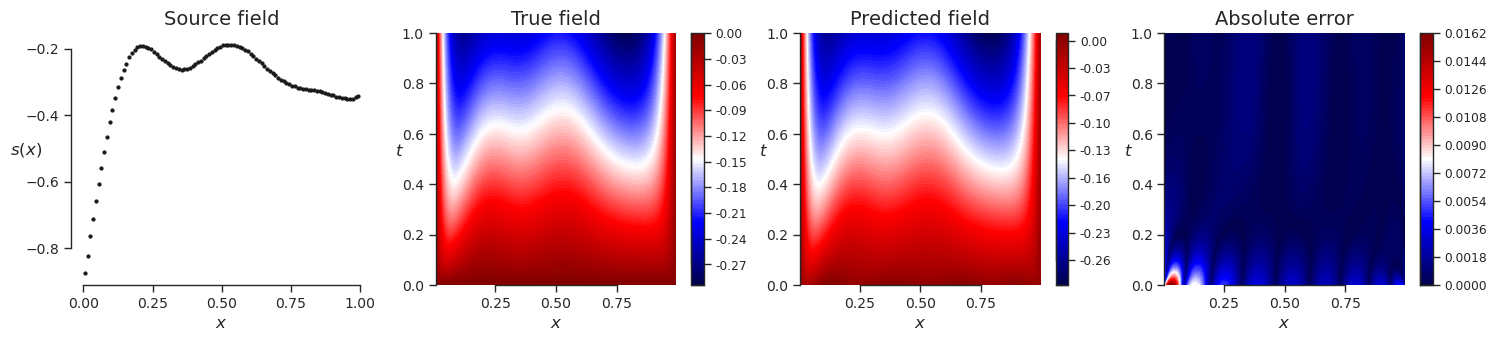

######################################################################################################################################################################################################################################
TEST SAMPLE 160
Rel. L2 Error = 0.0046, R2 score = 1.0


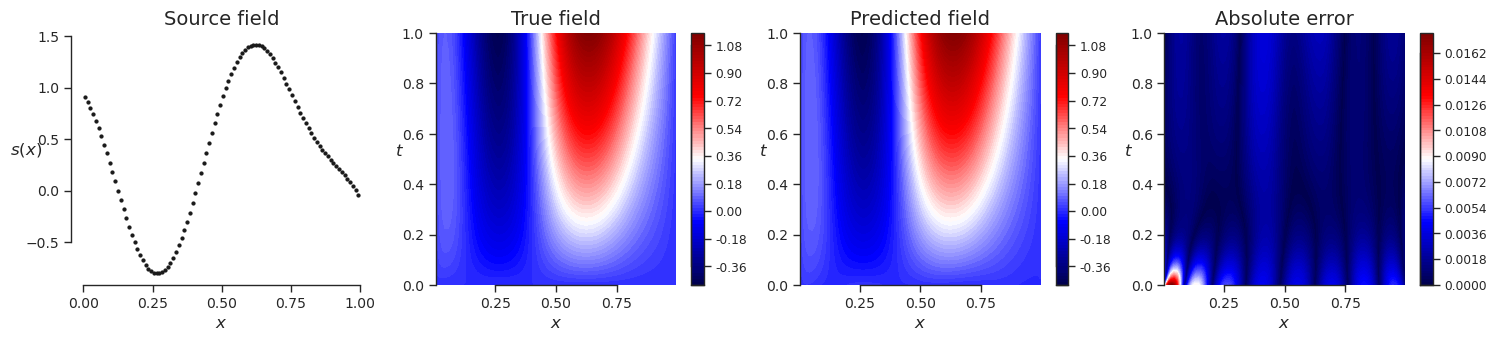

######################################################################################################################################################################################################################################
TEST SAMPLE 170
Rel. L2 Error = 0.0099, R2 score = 0.9998


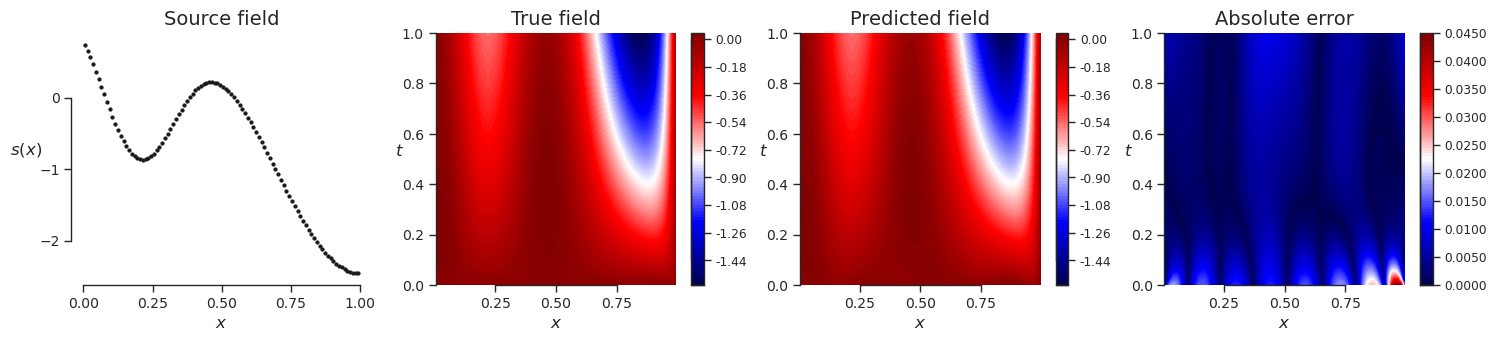

######################################################################################################################################################################################################################################
TEST SAMPLE 180
Rel. L2 Error = 0.0023, R2 score = 1.0


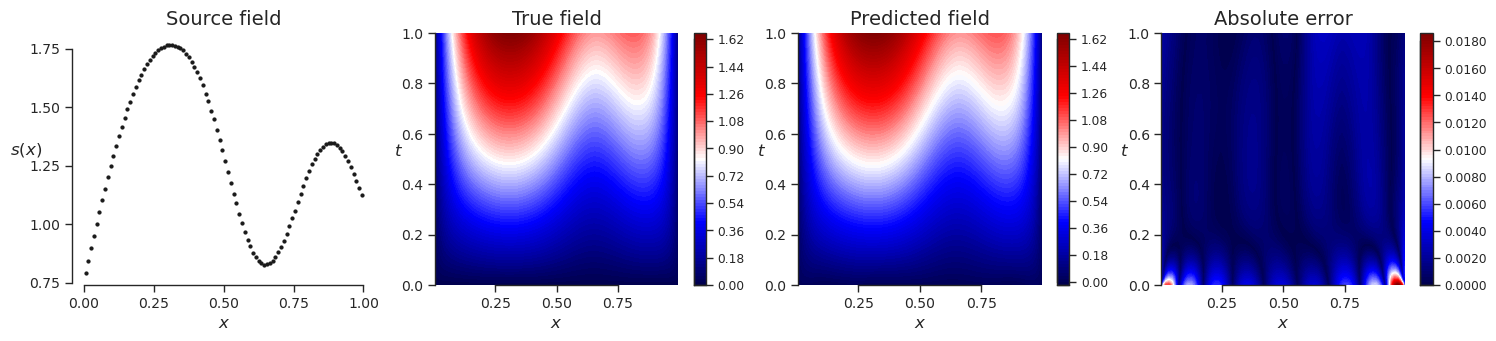

######################################################################################################################################################################################################################################
TEST SAMPLE 190
Rel. L2 Error = 0.0102, R2 score = 0.9999


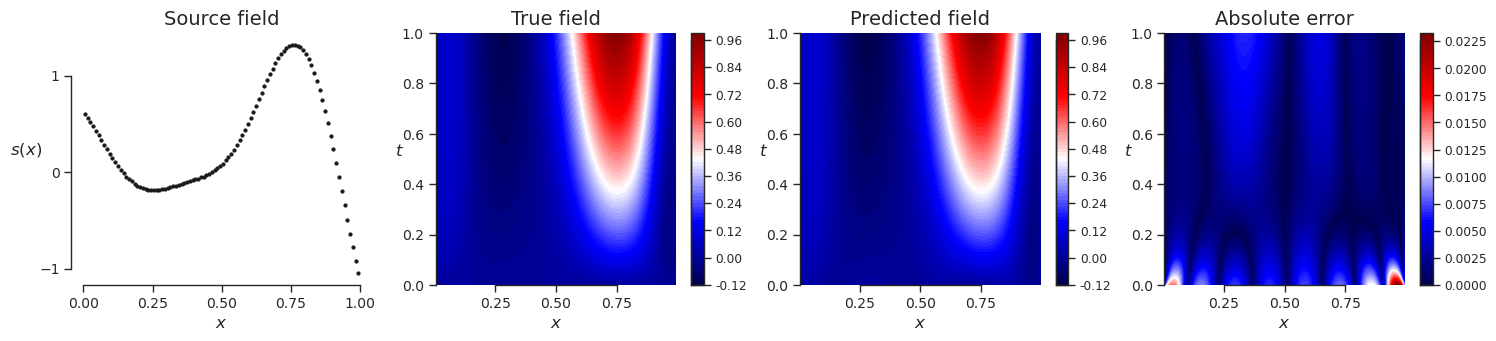

######################################################################################################################################################################################################################################
TEST SAMPLE 200
Rel. L2 Error = 0.0065, R2 score = 0.9999


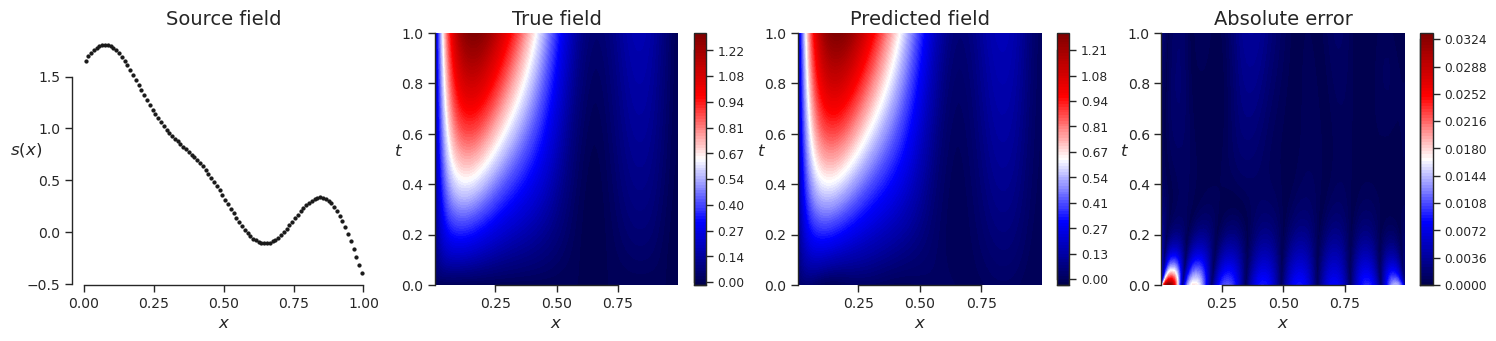

######################################################################################################################################################################################################################################
TEST SAMPLE 210
Rel. L2 Error = 0.0099, R2 score = 0.9999


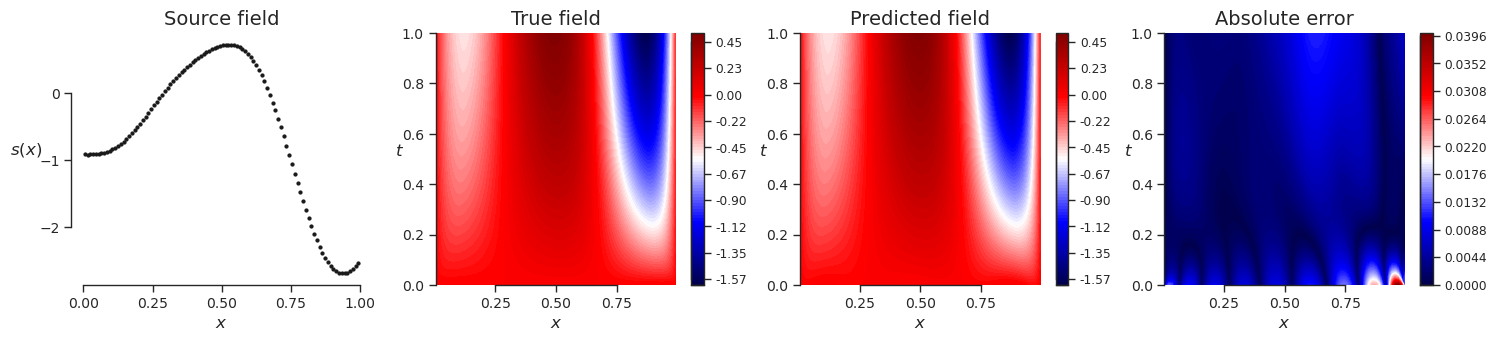

######################################################################################################################################################################################################################################
TEST SAMPLE 220
Rel. L2 Error = 0.0085, R2 score = 0.9999


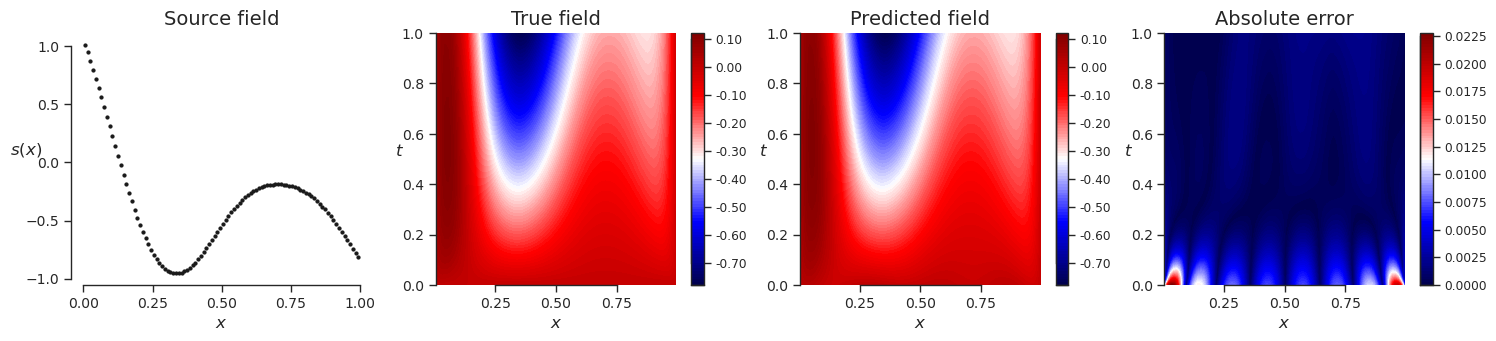

######################################################################################################################################################################################################################################
TEST SAMPLE 230
Rel. L2 Error = 0.0041, R2 score = 1.0


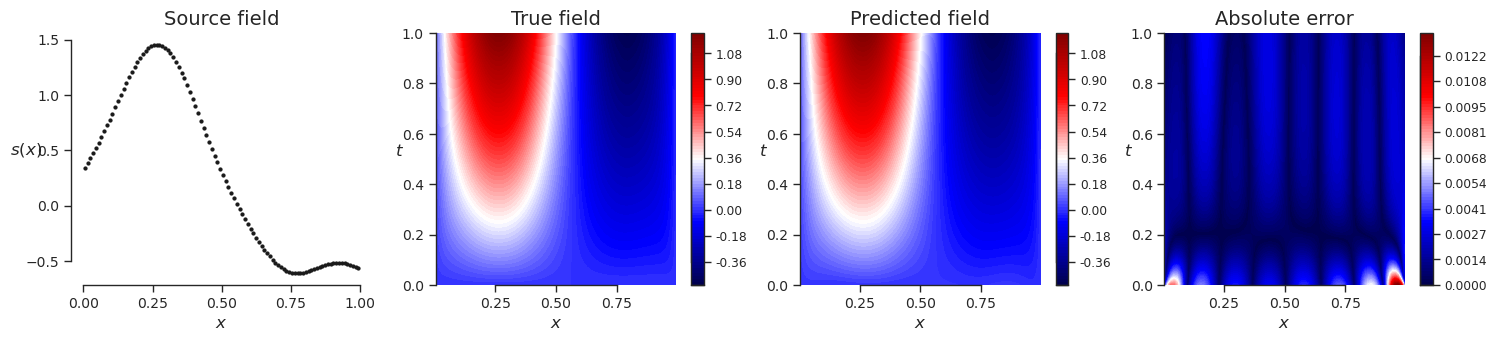

######################################################################################################################################################################################################################################
TEST SAMPLE 240
Rel. L2 Error = 0.0047, R2 score = 1.0


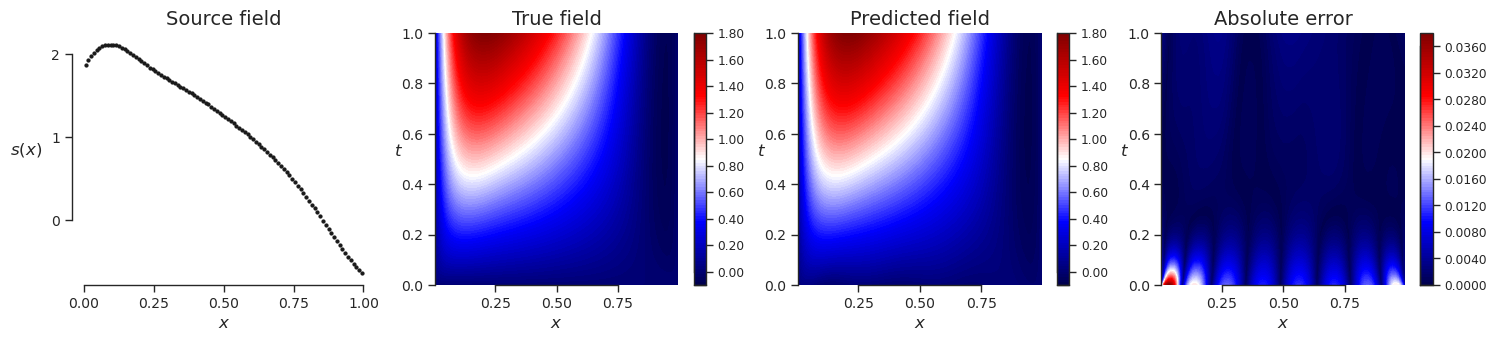

######################################################################################################################################################################################################################################
TEST SAMPLE 250
Rel. L2 Error = 0.0071, R2 score = 0.9999


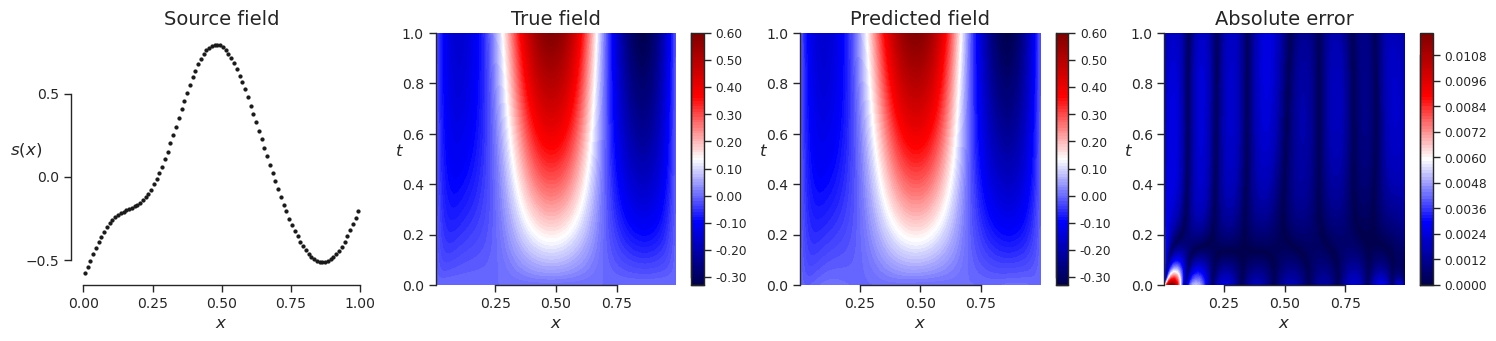

######################################################################################################################################################################################################################################
TEST SAMPLE 260
Rel. L2 Error = 0.0032, R2 score = 1.0


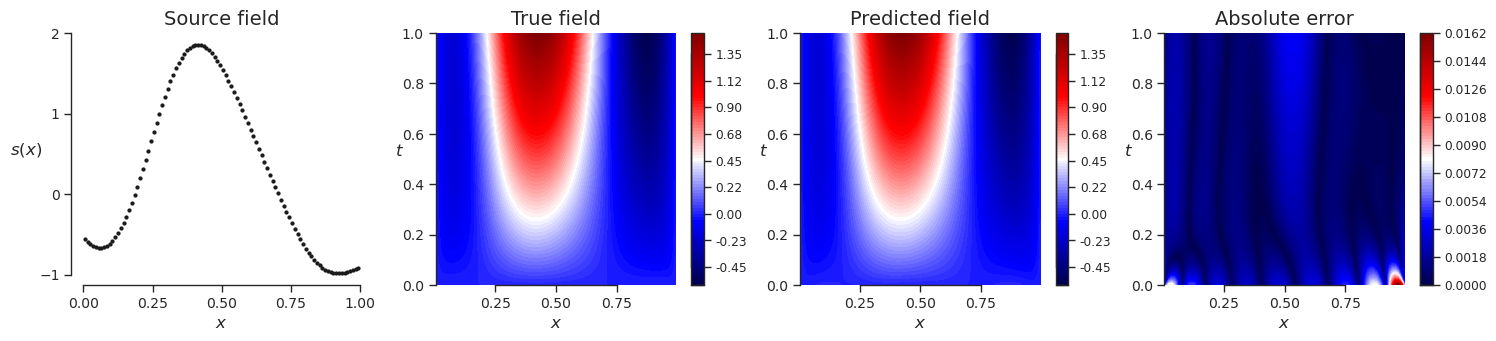

######################################################################################################################################################################################################################################
TEST SAMPLE 270
Rel. L2 Error = 0.0022, R2 score = 1.0


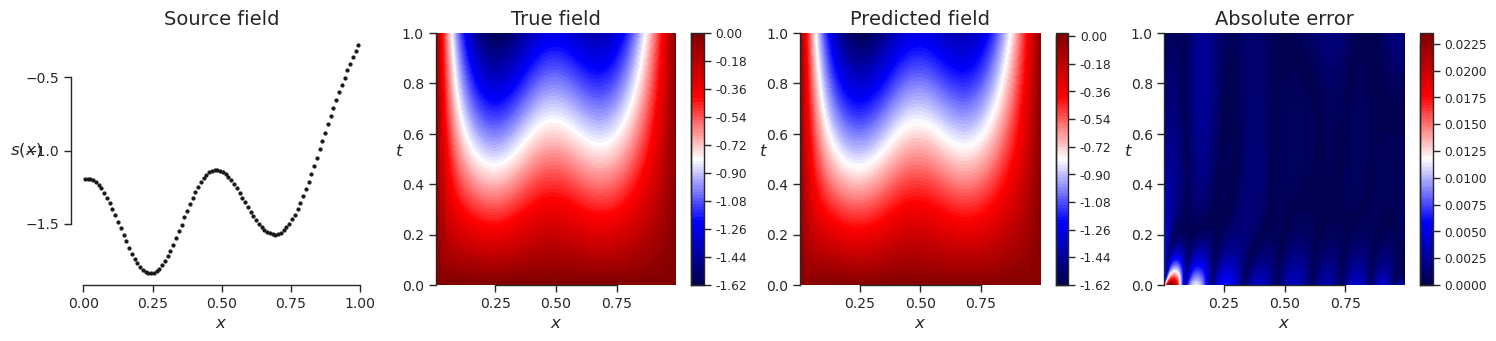

######################################################################################################################################################################################################################################
TEST SAMPLE 280
Rel. L2 Error = 0.0081, R2 score = 0.9999


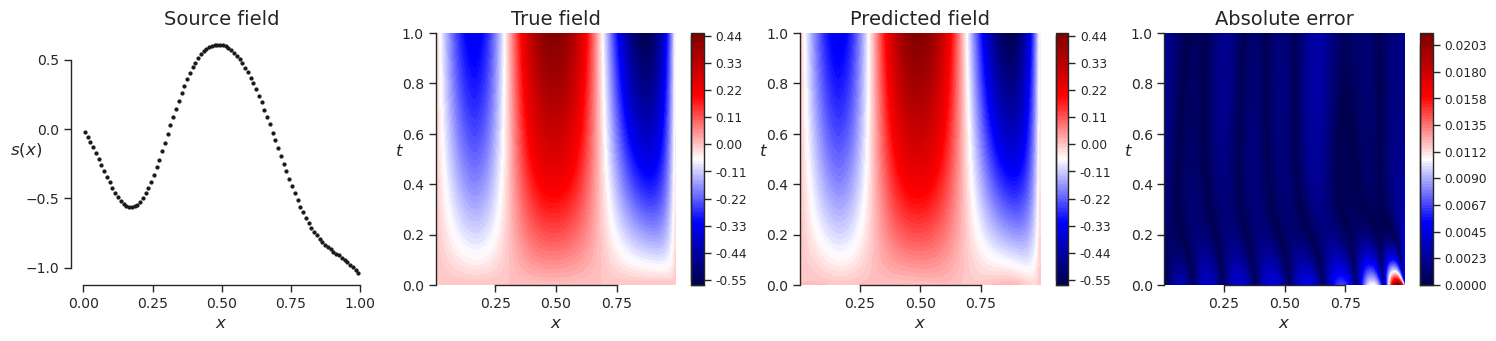

######################################################################################################################################################################################################################################
TEST SAMPLE 290
Rel. L2 Error = 0.0079, R2 score = 0.9999


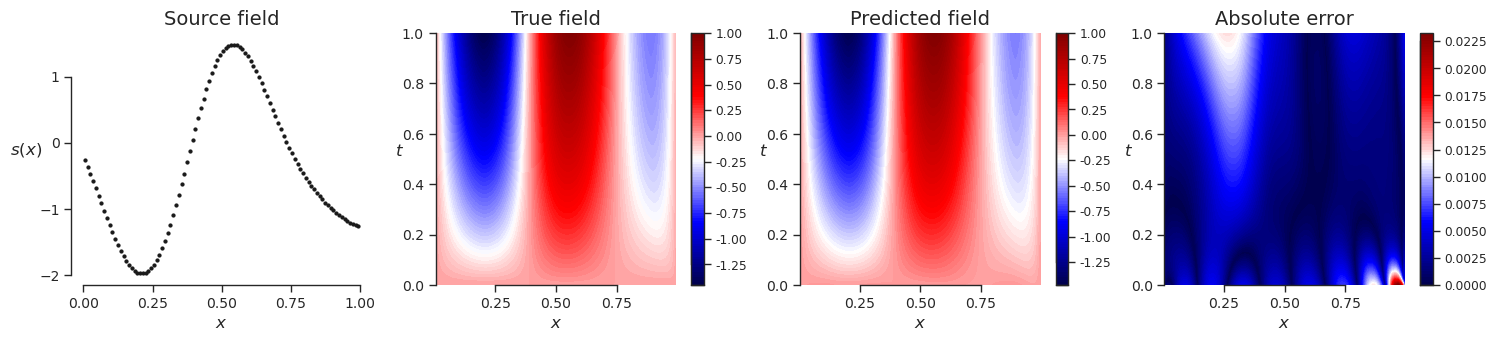

######################################################################################################################################################################################################################################
TEST SAMPLE 300
Rel. L2 Error = 0.0129, R2 score = 0.9998


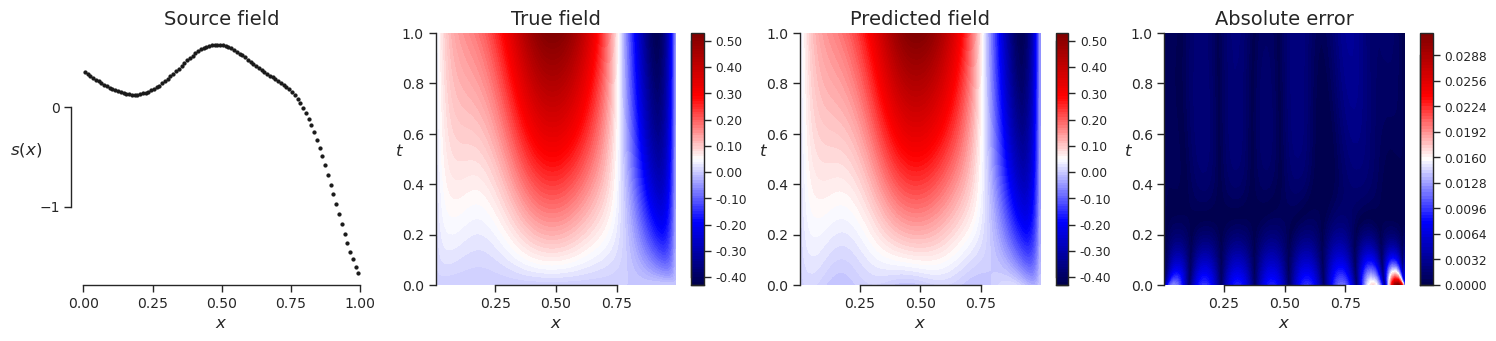

######################################################################################################################################################################################################################################
TEST SAMPLE 310
Rel. L2 Error = 0.0034, R2 score = 1.0


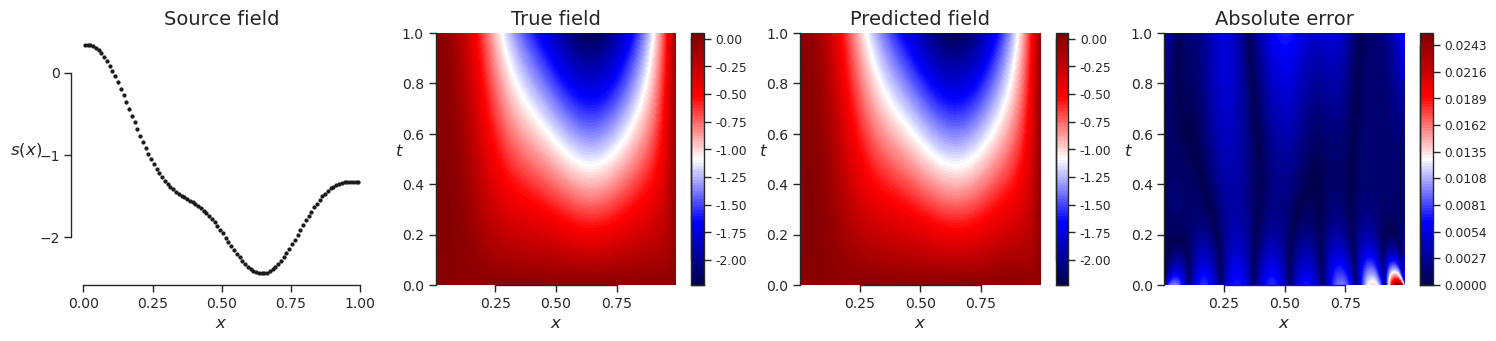

######################################################################################################################################################################################################################################
TEST SAMPLE 320
Rel. L2 Error = 0.0045, R2 score = 1.0


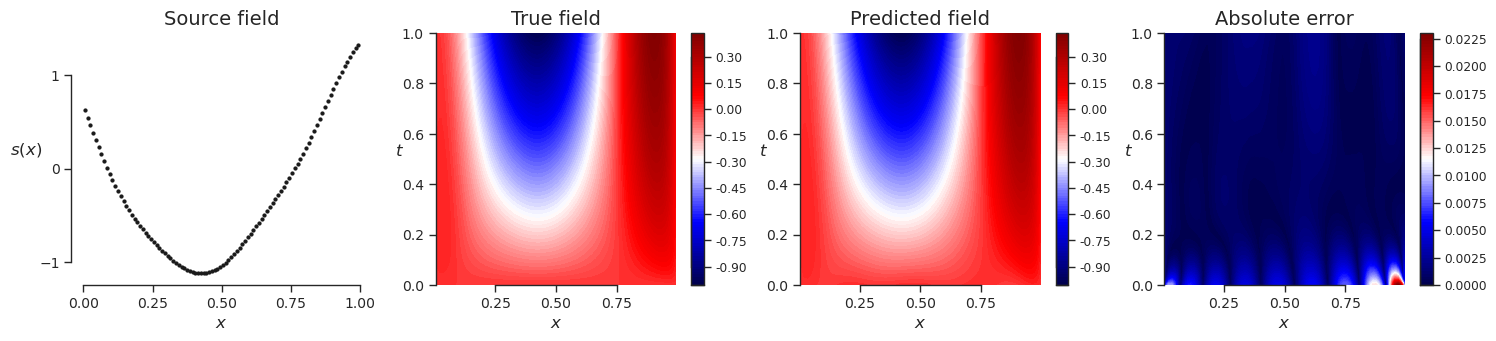

######################################################################################################################################################################################################################################
TEST SAMPLE 330
Rel. L2 Error = 0.003, R2 score = 1.0


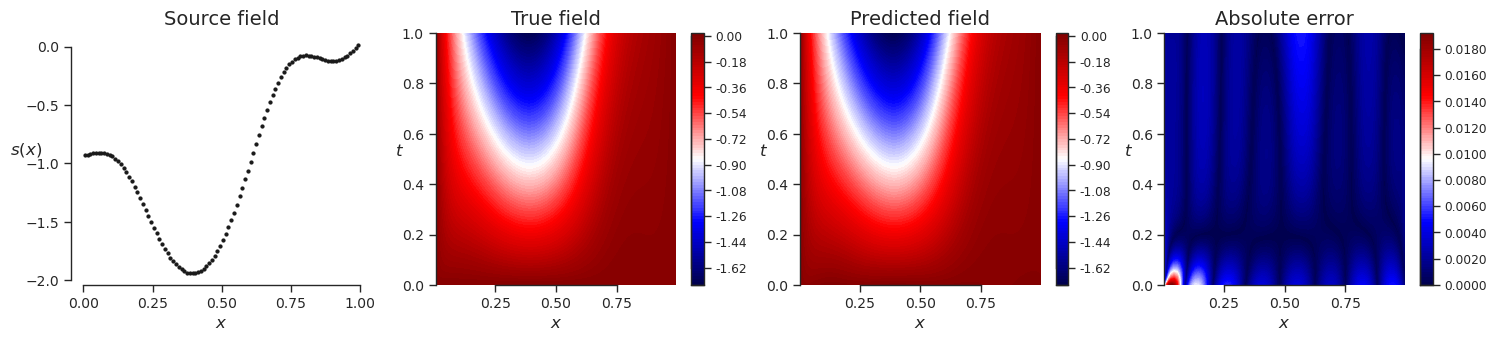

######################################################################################################################################################################################################################################
TEST SAMPLE 340
Rel. L2 Error = 0.0026, R2 score = 1.0


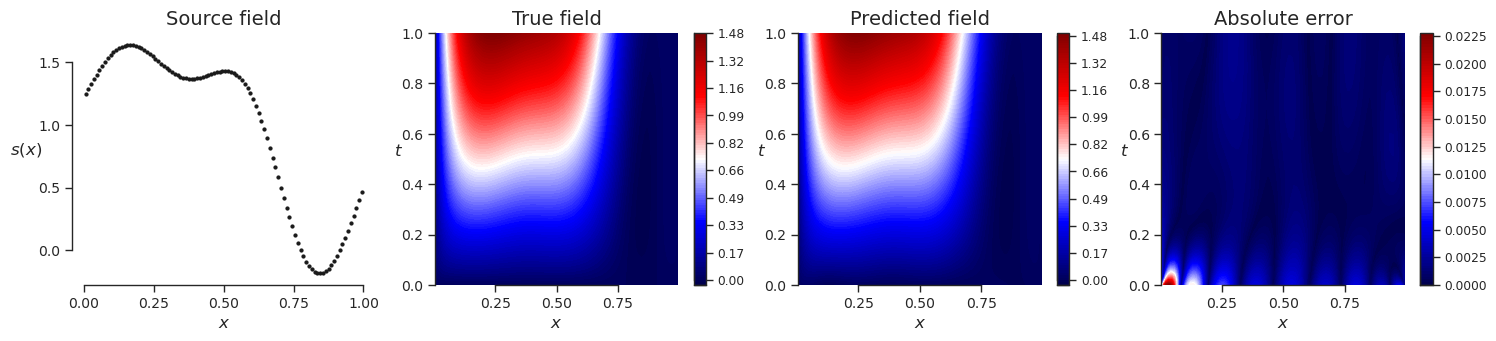

######################################################################################################################################################################################################################################
TEST SAMPLE 350
Rel. L2 Error = 0.007, R2 score = 0.9999


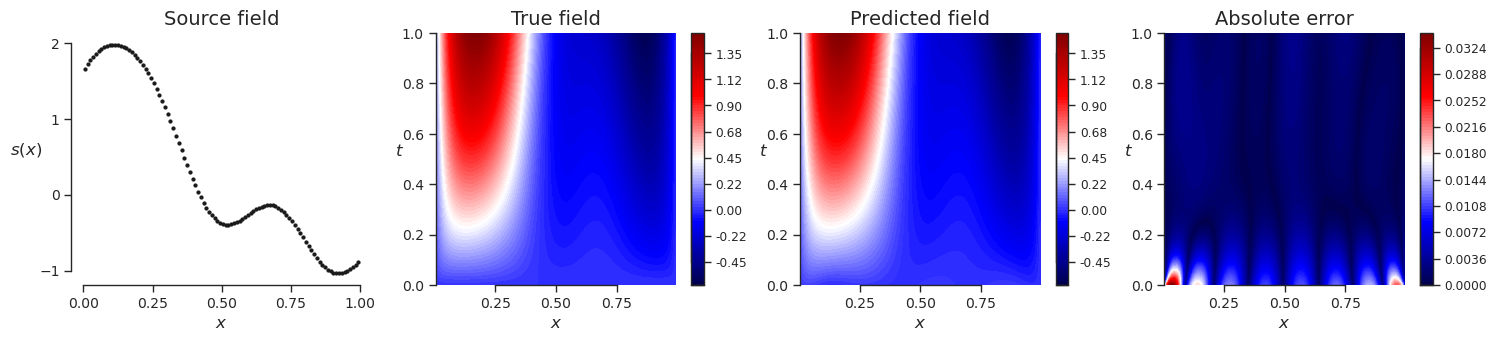

######################################################################################################################################################################################################################################
TEST SAMPLE 360
Rel. L2 Error = 0.003, R2 score = 1.0


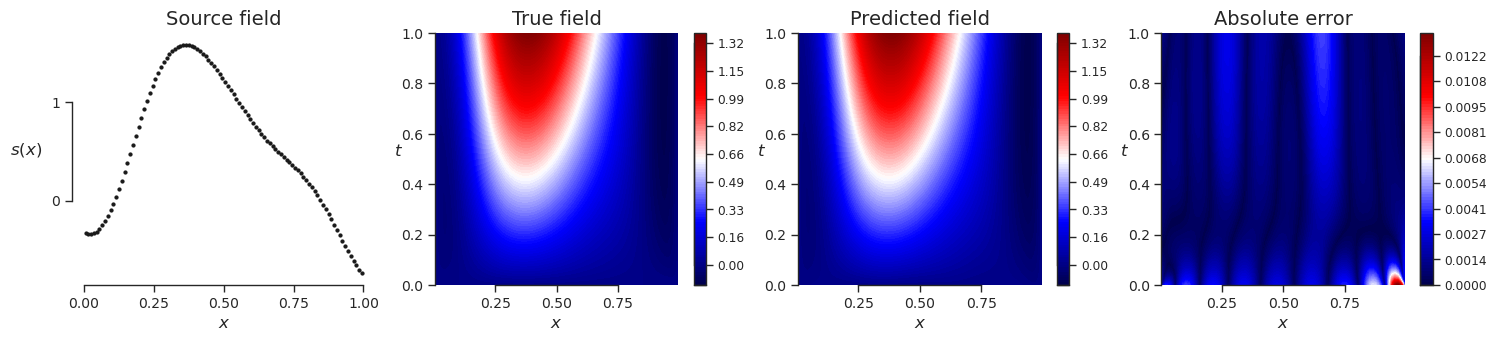

######################################################################################################################################################################################################################################
TEST SAMPLE 370
Rel. L2 Error = 0.0126, R2 score = 0.9998


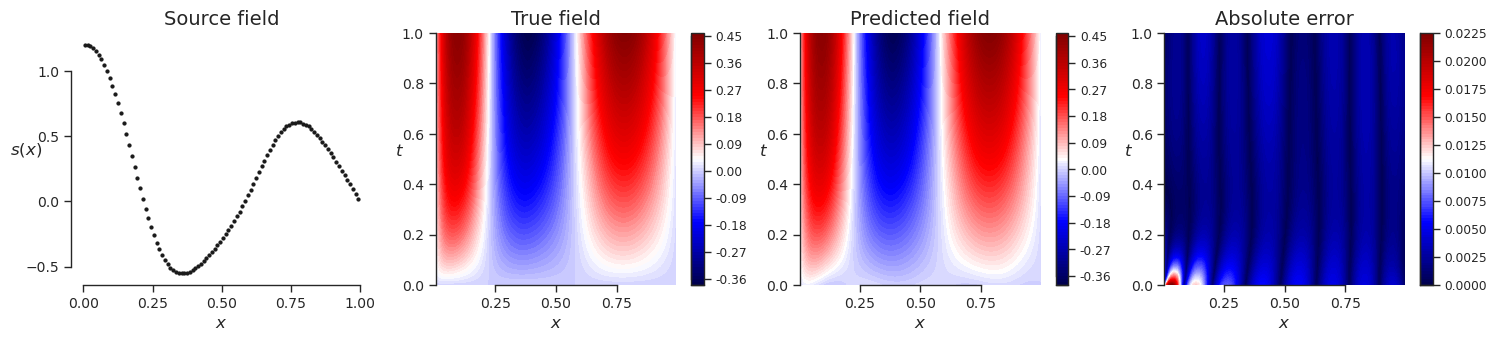

######################################################################################################################################################################################################################################
TEST SAMPLE 380
Rel. L2 Error = 0.0118, R2 score = 0.9998


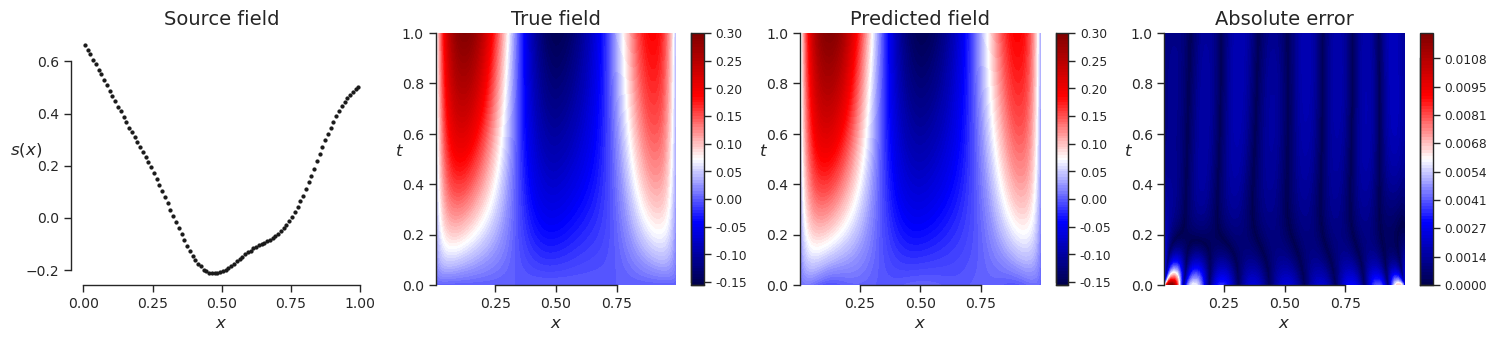

######################################################################################################################################################################################################################################
TEST SAMPLE 390
Rel. L2 Error = 0.0057, R2 score = 0.9999


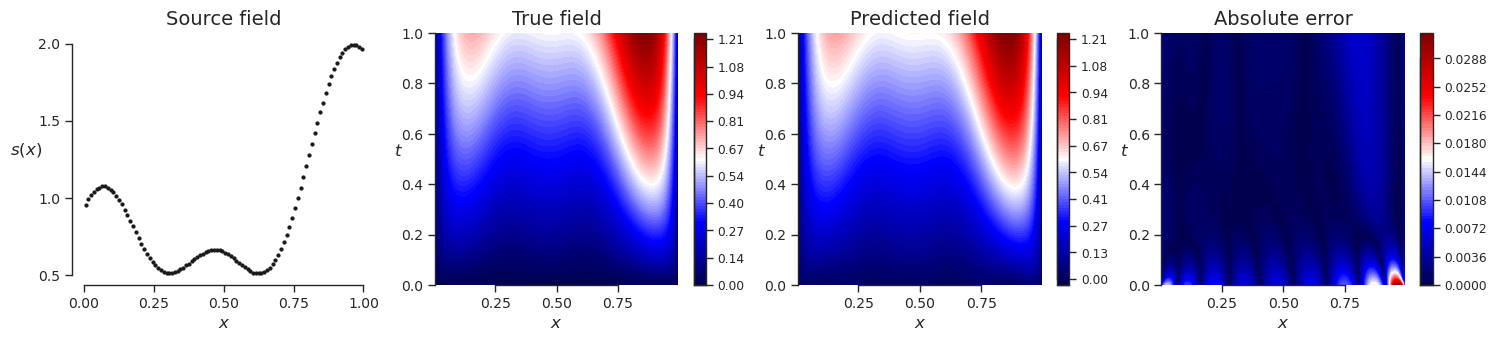

######################################################################################################################################################################################################################################
TEST SAMPLE 400
Rel. L2 Error = 0.0024, R2 score = 1.0


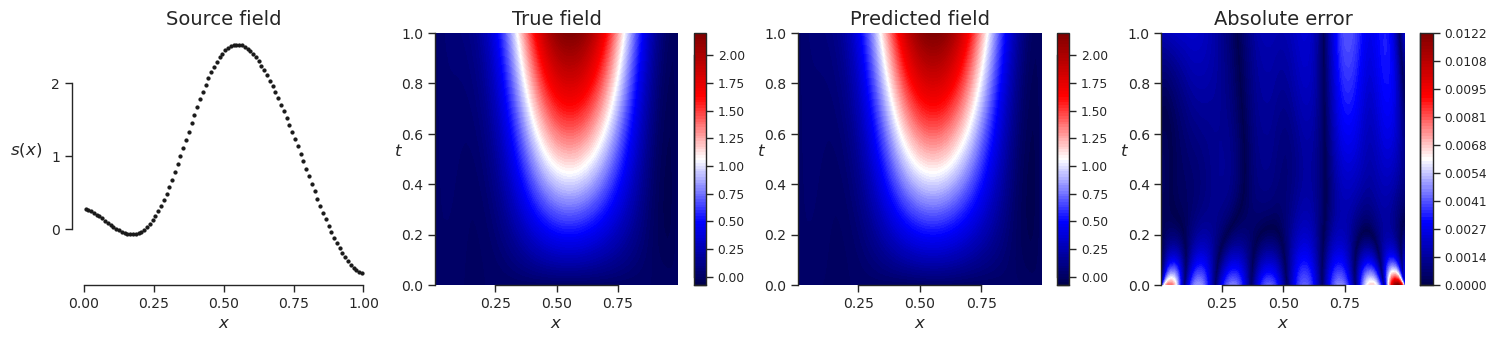

######################################################################################################################################################################################################################################
TEST SAMPLE 410
Rel. L2 Error = 0.0043, R2 score = 1.0


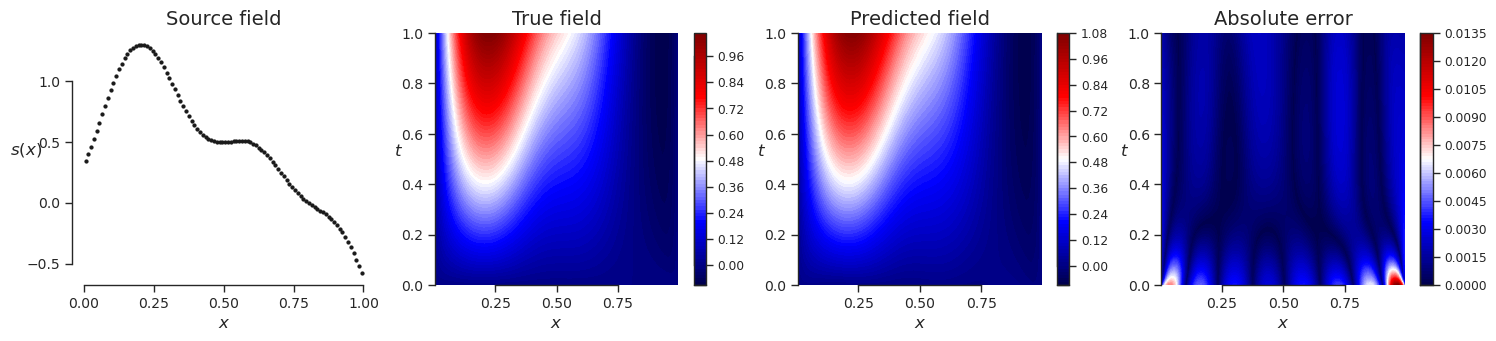

######################################################################################################################################################################################################################################
TEST SAMPLE 420
Rel. L2 Error = 0.0074, R2 score = 0.9999


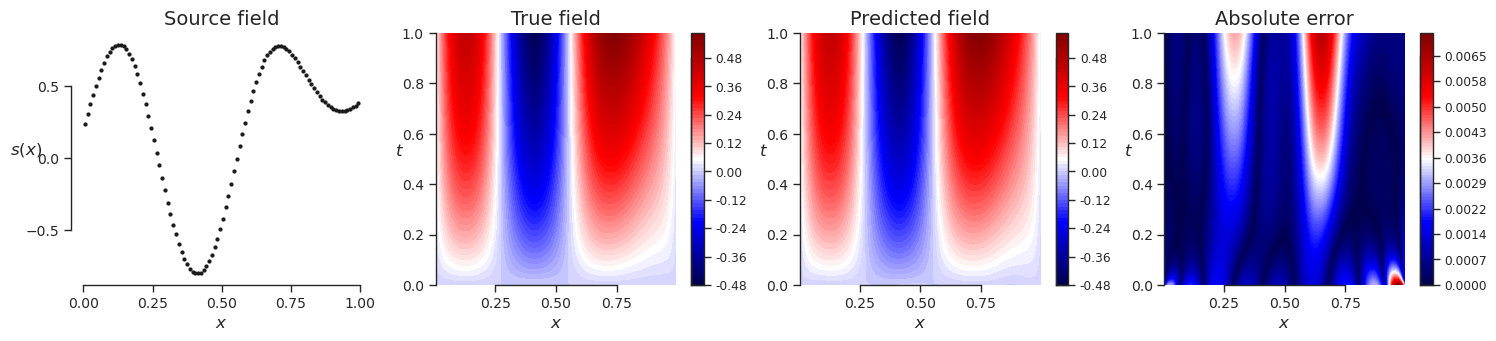

######################################################################################################################################################################################################################################
TEST SAMPLE 430
Rel. L2 Error = 0.0023, R2 score = 1.0


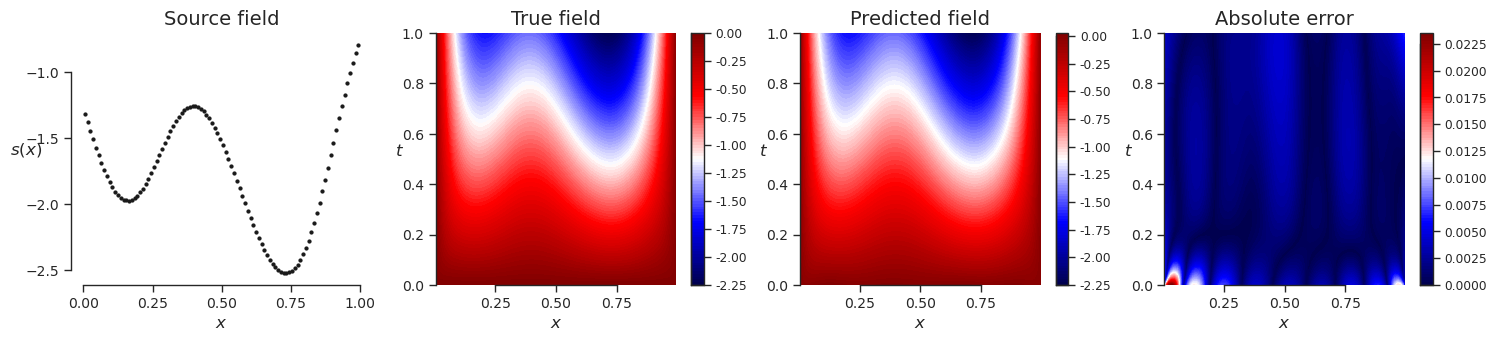

######################################################################################################################################################################################################################################
TEST SAMPLE 440
Rel. L2 Error = 0.0079, R2 score = 0.9998


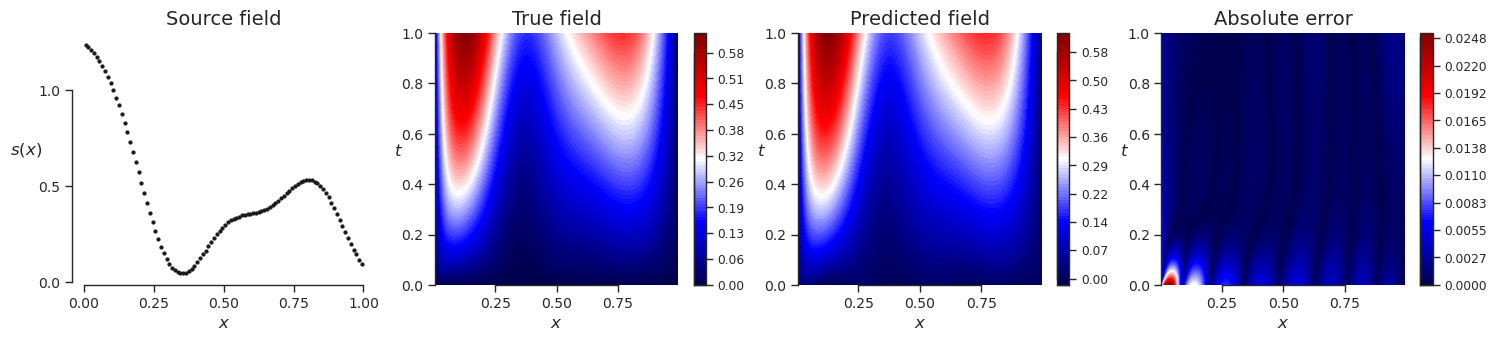

######################################################################################################################################################################################################################################
TEST SAMPLE 450
Rel. L2 Error = 0.0059, R2 score = 0.9999


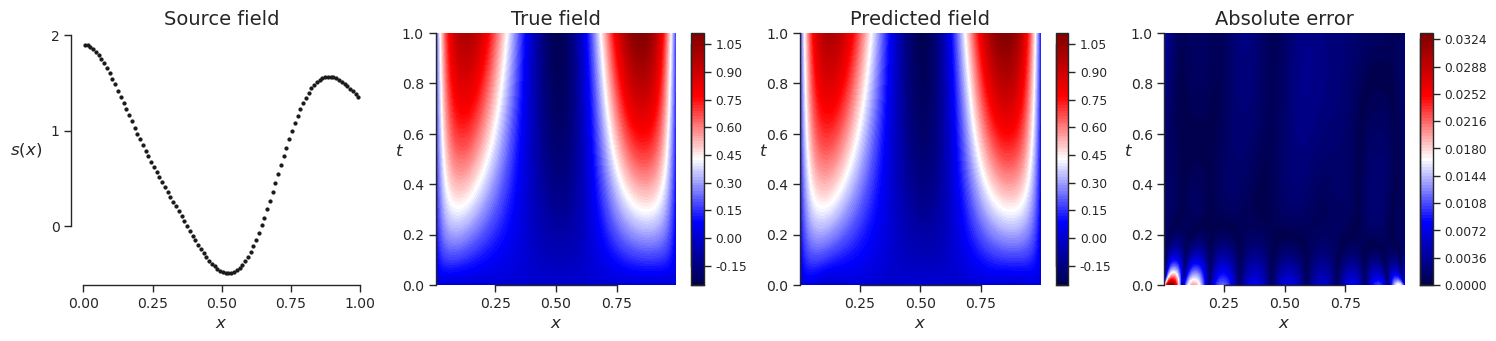

######################################################################################################################################################################################################################################
TEST SAMPLE 460
Rel. L2 Error = 0.0094, R2 score = 0.9999


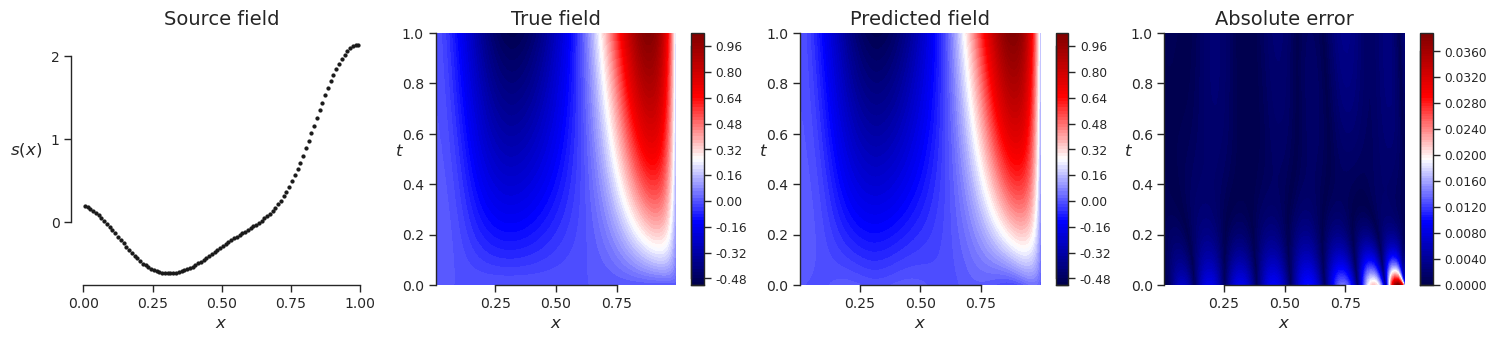

######################################################################################################################################################################################################################################
TEST SAMPLE 470
Rel. L2 Error = 0.0085, R2 score = 0.9998


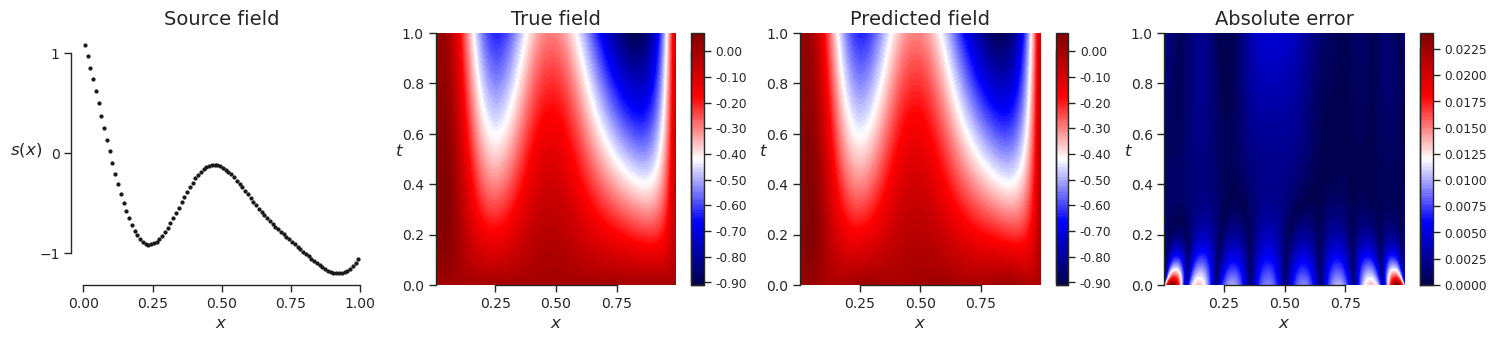

######################################################################################################################################################################################################################################
TEST SAMPLE 480
Rel. L2 Error = 0.0088, R2 score = 0.9999


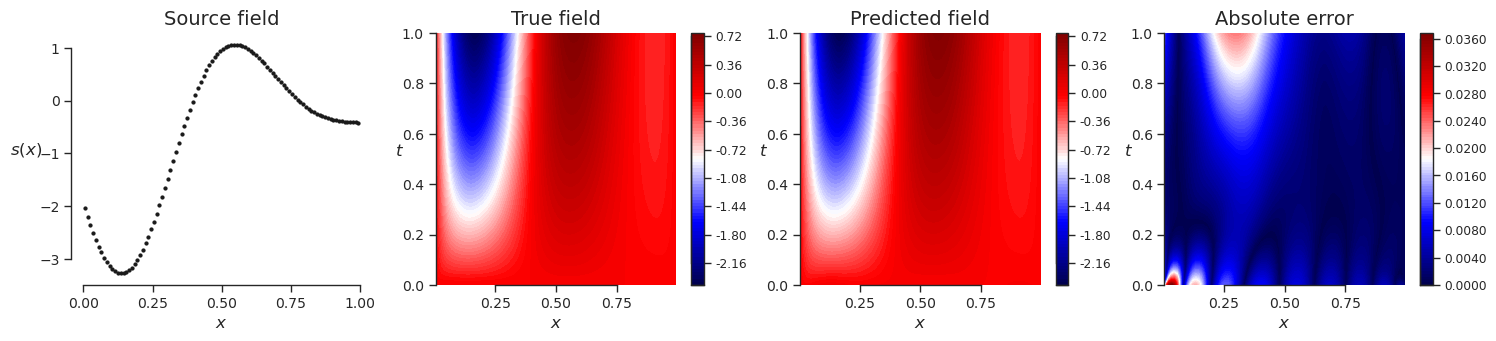

######################################################################################################################################################################################################################################
TEST SAMPLE 490
Rel. L2 Error = 0.0039, R2 score = 1.0


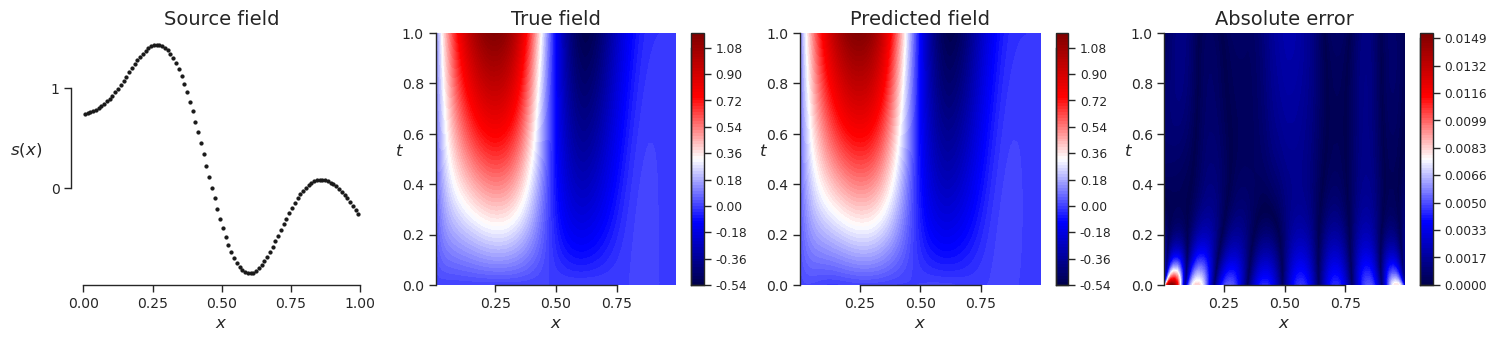

######################################################################################################################################################################################################################################
TEST SAMPLE 500
Rel. L2 Error = 0.0144, R2 score = 0.9998


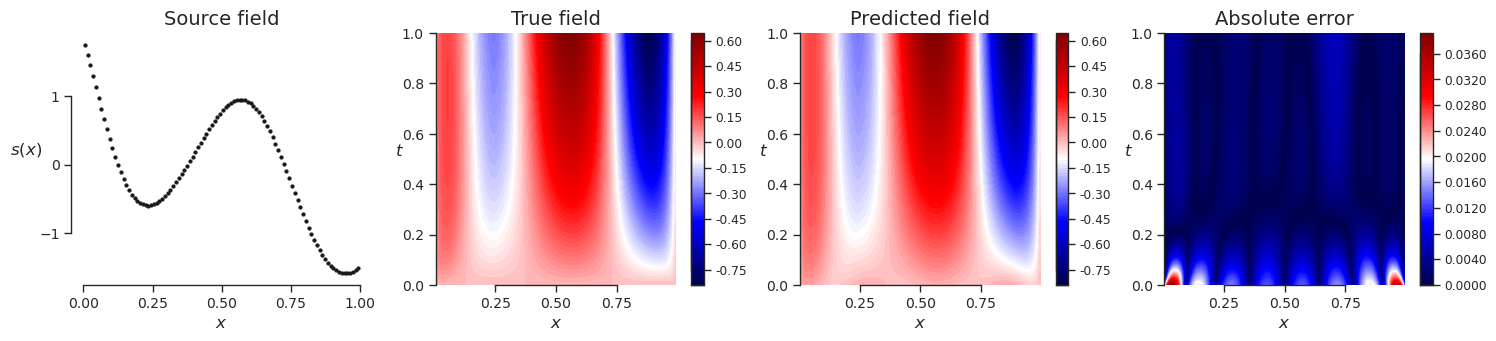

######################################################################################################################################################################################################################################
Mean Squared Error Test:
 7.284226802255489e-06
R2 score Test:
 0.9999374540170766
Rel. L2 Error Test:
 0.005823454435216263


In [18]:
# Predictions
latent_branch_inputs = inputs_test # (bs, m) = (bs, nx) 
latent_trunk_inputs = t_span.reshape(-1, 1) # (nt, 1)
reconstruction_trunk_inputs = x_span.reshape(-1, 1) # (nx, 1)
_, reconstruction_predictions_test = model(latent_branch_inputs, latent_trunk_inputs, reconstruction_trunk_inputs)# (bs, nt, latent_dim), (bs, nt, nx)
# print(reconstruction_predictions_test.shape)

mse_list, r2score_list, relerror_list = [], [], [] 

for i in range(inputs_test.shape[0]):

    reconstruction_prediction_i = reconstruction_predictions_test[i].unsqueeze(0) # (1, nt, nx)
    reconstruction_target_i = outputs_test[i].unsqueeze(0) # (1, nt, nx)
    
    reconstruction_mse_i = F.mse_loss(reconstruction_prediction_i.cpu(), reconstruction_target_i.cpu())
    mse_i = reconstruction_mse_i
    
    r2score_i = metrics.r2_score(reconstruction_target_i.flatten().cpu().detach().numpy(), reconstruction_prediction_i.flatten().cpu().detach().numpy()) 
    relerror_i = np.linalg.norm(reconstruction_target_i.flatten().cpu().detach().numpy() - reconstruction_prediction_i.flatten().cpu().detach().numpy()) / np.linalg.norm(reconstruction_target_i.flatten().cpu().detach().numpy())

    mse_list.append(mse_i.item())
    r2score_list.append(r2score_i.item())
    relerror_list.append(relerror_i.item())

    if (i+1) % 10 == 0:
        plot_predictions(i, resultdir, reconstruction_target_i, reconstruction_prediction_i, x_span, inputs_test, X, T, nt, nx, r'$s(x)$', 'Source field', 'seismic', save)
        
mse = sum(mse_list) / len(mse_list)
print("Mean Squared Error Test:\n", mse)
r2score = sum(r2score_list) / len(r2score_list)
print("R2 score Test:\n", r2score)
relerror = sum(relerror_list) / len(relerror_list)
print("Rel. L2 Error Test:\n", relerror)

In [19]:
test_dict = {
    "inputs_test": inputs_test.cpu(),
    "outputs_test": outputs_test.cpu(),
    "predictions_test": reconstruction_predictions_test.cpu()
}
for key, value in test_dict.items():
    print(f"Shape of {key}: {value.shape}")
print(colored('#'*230, 'green'))

if save == True:
    torch.save(test_dict, os.path.join(resultdir,'test_dict.pth'))

Shape of inputs_test: torch.Size([500, 100])
Shape of outputs_test: torch.Size([500, 101, 100])
Shape of predictions_test: torch.Size([500, 101, 100])
######################################################################################################################################################################################################################################


In [20]:
performance_metrics(mse, r2score, relerror, training_time, runtime_per_iter, resultdir, save)

Mean Squared Error Test:
7.284226802255489e-06
R2 score Test:
0.9999374540170766
Rel. L2 Error Test:
0.005823454435216263
Training Time (in sec):
2052.073276758194
Runtime per Iteration (in sec/iter):
0.041
